## PyTorch modules and layers

### What are modules?
Module is an abstraction somewhere between neural network *layer* and complete *model*. In PyTorch, there all kinds of things one can do with modules and their combinations.

![Multiple layers are combined into modules, forming repeating patterns of larger models.](./img/blocks.svg)

From a programming standpoint, a module is represented by a class. Any subclass of it must:
  - define a forward propagation method that transforms its input into output
  - store any necessary parameters.

Start with necessary imports:

In [1]:
#!pip install torch

   ---------------------------------------- 0.0/228.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/228.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/228.5 MB 495.5 kB/s eta 0:07:42
   ---------------------------------------- 0.2/228.5 MB 1.5 MB/s eta 0:02:32
   ---------------------------------------- 0.5/228.5 MB 3.2 MB/s eta 0:01:11
   ---------------------------------------- 0.8/228.5 MB 4.0 MB/s eta 0:00:58
   ---------------------------------------- 1.1/228.5 MB 4.2 MB/s eta 0:00:54
   ---------------------------------------- 1.2/228.5 MB 4.4 MB/s eta 0:00:52
   ---------------------------------------- 2.4/228.5 MB 7.1 MB/s eta 0:00:32
   ---------------------------------------- 2.5/228.5 MB 7.3 MB/s eta 0:00:32
    --------------------------------------- 3.3/228.5 MB 7.9 MB/s eta 0:00:29
    --------------------------------------- 3.7/228.5 MB 8.1 MB/s eta 0:00:28
    --------------------------------------- 4.0/228.5 MB 8.0 MB/s eta 0:00:2

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\anaconda\\Library\\bin\\mkl_core.1.dll'
Consider using the `--user` option or check the permissions.



In [14]:
import torch
from torch import nn
from torch.nn import functional as F

### Module chaining
We can use a built-in `Sequential` function to chain layers together. The below code creates a hidden layer with 256 neurons and ReLU activation function, and an output layer with 10 neurons:

In [15]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

X = torch.rand(2, 20)
net(X).shape

D:\anaconda\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 10])

### Forward propagation
**Important**: to use the model, we pass it the input data (`net(X)` in the above example). This executes the model's forward, along with some background operations.

`net(X)` is actually just shorthand for `net.__call__(X)`. `LazyLinear` is a version of `Linear` that *infers* output dimensions.

In [16]:
X.shape

torch.Size([2, 20])

### Create a module from scratch
In the following snippet, we code up a module from scratch corresponding to an MLP with one hidden layer with 256 hidden units, and a 10- dimensional output layer. Note that the MLP class below inherits the class that represents a module. We will heavily rely on the parent class’s methods, supplying only our own constructor (the __init__ method in Python) and the forward propagation method.

In [17]:
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

Let’s first focus on the forward propagation method. Note that it takes X as input, calculates the hidden representation with the activation function applied, and outputs its logits. In this MLP implementation, both layers are instance variables. To see why this is reasonable, imagine instantiating two MLPs, net1 and net2, and training them on different data. Naturally, we would expect them to represent two different learned models.

In [18]:
net = MLP()
net(X).shape

torch.Size([2, 10])

**So**: a module can abstract layers, complete models, or anything in-between.

### Writing your own `Sequential`

We need to define two key methods:

1. A method for appending modules one by one to a list.
2. A forward propagation method for passing an input through the chain of modules, in the same order as they were appended.


In [19]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

Note `add_module` and `children` funcs.

Now we can use it:

In [20]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

### Executing Code in the Forward Propagation Method

The `Sequential` class makes model construction easy,
allowing us to assemble new architectures
without having to define our own class.
However, not all architectures are simple daisy chains.
When greater flexibility is required,
we will want to define our own blocks.
For example, we might want to execute
Python's control flow within the forward propagation method.
Moreover, we might want to perform
arbitrary mathematical operations,
not simply relying on predefined neural network layers.

You may have noticed that until now,
all of the operations in our networks
have acted upon our network's activations
and its parameters.
Sometimes, however, we might want to
incorporate terms
that are neither the result of previous layers
nor updatable parameters.
We call these *constant parameters*.
Say for example that we want a layer
that calculates the function
$f(\mathbf{x},\mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}$,
where $\mathbf{x}$ is the input, $\mathbf{w}$ is our parameter,
and $c$ is some specified constant
that is not updated during optimization.
So we implement a `FixedHiddenMLP` class as follows.

In [21]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In this model,
we implement a hidden layer whose weights
(`self.rand_weight`) are initialized randomly
at instantiation and are thereafter constant.
This weight is not a model parameter
and thus it is never updated by backpropagation.
The network then passes the output of this "fixed" layer
through a fully connected layer.

Note that before returning the output,
our model did something unusual.
We ran a while-loop, testing
on the condition its $\ell_1$ norm is larger than $1$,
and dividing our output vector by $2$
until it satisfied the condition.
Finally, we returned the sum of the entries in `X`.
To our knowledge, no standard neural network
performs this operation.
Note that this particular operation may not be useful
in any real-world task.
Our point is only to show you how to integrate
arbitrary code into the flow of your
neural network computations.

In [22]:
net = FixedHiddenMLP()
net(X)

tensor(-0.3910, grad_fn=<SumBackward0>)

We can mix and match various ways of assembling modules together. In the following example, we nest modules in some creative ways.

In [23]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)

tensor(0.2138, grad_fn=<SumBackward0>)

### Parameters
Once we have chosen an architecture
and set our hyperparameters,
we proceed to the training loop,
where our goal is to find parameter values
that minimize our loss function.
After training, we will need these parameters
in order to make future predictions.
Additionally, we will sometimes wish
to extract the parameters
perhaps to reuse them in some other context,
to save our model to disk so that
it may be executed in other software,
or for examination in the hope of
gaining scientific understanding.

Most of the time, we will be able
to ignore the nitty-gritty details
of how parameters are declared
and manipulated, relying on deep learning frameworks
to do the heavy lifting.
However, when we move away from
stacked architectures with standard layers,
we will sometimes need to get into the weeds
of declaring and manipulating parameters.
In this section, we cover the following:

* Accessing parameters for debugging, diagnostics, and visualizations.
* Sharing parameters across different model components.

Let's use an MLP with one hidden layer:

In [24]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [25]:
X

tensor([[0.7329, 0.2642, 0.6332, 0.4932],
        [0.8720, 0.4709, 0.6321, 0.0631]])

How do we access each layer's parameters? Via indexing.

In [26]:
net[0].state_dict()

OrderedDict([('weight',
              tensor([[ 0.2251, -0.1463,  0.2536,  0.2143],
                      [ 0.4328, -0.2559,  0.2237,  0.3911],
                      [-0.0253,  0.0714,  0.1986, -0.3750],
                      [ 0.0441,  0.0834,  0.4554,  0.4023],
                      [-0.1554, -0.2755, -0.3663, -0.1340],
                      [-0.1482, -0.2196,  0.3913, -0.0293],
                      [-0.4576,  0.2918,  0.0706, -0.2122],
                      [-0.3547, -0.0573,  0.4419,  0.0073]])),
             ('bias',
              tensor([-0.1731, -0.1299, -0.2800, -0.0335, -0.4767,  0.0565,  0.4513,  0.0290]))])

In [27]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.1806,  0.2123, -0.3421,  0.0955, -0.2609,  0.2469, -0.0516, -0.2674]])),
             ('bias', tensor([0.3262]))])

Note that parameters (weights/bias) are instances of a `torch.nn.parameter.Parameter` class.

In [28]:
net[2].weight

Parameter containing:
tensor([[ 0.1806,  0.2123, -0.3421,  0.0955, -0.2609,  0.2469, -0.0516, -0.2674]],
       requires_grad=True)

We can use `data` field in order to extract actual data:

In [29]:
net[2].weight.data

tensor([[ 0.1806,  0.2123, -0.3421,  0.0955, -0.2609,  0.2469, -0.0516, -0.2674]])

In [30]:
net[2].weight.shape

torch.Size([1, 8])

In [31]:
net[0].weight.shape

torch.Size([8, 4])

We can also access gradients for each layer:

In [32]:
net[2].weight.grad == None

True

We can also access parameters all at once via `nn.Module.named_parameters()`:

In [33]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

We can also tie or connect/share parameters in different layers.

In the following we allocate a fully connected layer
and then use its parameters specifically
to set those of another layer.
Here we need to run the forward propagation
`net(X)` before accessing the parameters.

In [34]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


This example shows that the parameters
of the second and third layer are tied.
They are not just equal, they are
represented by the same exact tensor.
Thus, if we change one of the parameters,
the other one changes, too.

You might wonder,
when parameters are tied
what happens to the gradients?
Since the model parameters contain gradients,
the gradients of the second hidden layer
and the third hidden layer are added together
during backpropagation.



### Initialization

By default, PyTorch initializes weight and bias matrices uniformly by drawing from a range that is computed according to the input and output dimension. PyTorch’s nn.init module provides a variety of preset initialization methods.

Let's start with a sample neural network built with `nn.Sequential`.

In [35]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

### Built-in initializers

This code will initialize weights as Guassian random variables, and biases will be 0. The `apply` method applies the given function recursively to each submodule:

In [36]:
def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0022,  0.0149, -0.0177,  0.0106]), tensor(0.))

Or we can use constants:

In [37]:
def init_constant(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 1)
        nn.init.zeros_(module.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

We can use indexing to initialize parameters for each layer separately:

In [38]:
def init_xavier(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

def init_42(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.4658,  0.5089, -0.1560,  0.1889])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


Sometimes, the initialization methods we need
are not provided by the deep learning framework.
In the example below, we define an initializer
for any weight parameter $w$ using the following strange distribution (here $U$ stands for uniform distribution):

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \textrm{ with probability } \frac{1}{4} \\
            0    & \textrm{ with probability } \frac{1}{2} \\
        U(-10, -5) & \textrm{ with probability } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


In [39]:
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000,  8.7587, -0.0000,  7.0312],
        [ 7.9342, -8.1187, -5.7389, -0.0000]], grad_fn=<SliceBackward0>)

And, of course, we can always set the parameters directly:

In [40]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  9.7587,  1.0000,  8.0312])

Or in model class constructor:

In [41]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### Lazy initialization

PyTorch can defer parameter initialization, waiting until the first time we pass data through the model, to infer the sizes of each layer on the fly.

Later on, when working with convolutional neural networks, this technique will become even more convenient since the input dimensionality (e.g., the resolution of an image) will affect the dimensionality of each subsequent layer.

Let's create some perceptron again:

In [42]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

Check first layer params:

In [43]:
net[0].weight

<UninitializedParameter>

We can pass some data:

In [44]:
X = torch.rand(2, 20)
net(X)

net[0].weight.shape

torch.Size([256, 20])

### Custom layers

Let's first try a layer without parameters:

In [45]:
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

Let's see if it works:

In [46]:
layer = CenteredLayer()
layer(torch.tensor([1.0, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

We can use it in some models now:

In [47]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

Check how it works:

In [48]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(7.4506e-09, grad_fn=<MeanBackward0>)

The very small number instead of 0 is due to floating point number arithmetic.

Let's now create a custom layer with parameters: `in_units` and `out_units` for inputs and outputs counts.

In [49]:
class MyLinear(nn.Module):
    def __init__(self, in_units, out_units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, out_units))
        self.bias = nn.Parameter(torch.randn(out_units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

We can instantiate it and check parameters:

In [50]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 1.1618, -0.7978,  2.0752],
        [-0.3190,  0.5153, -0.2028],
        [-1.4890,  0.0456, -0.5198],
        [ 0.5427,  0.0635, -0.3666],
        [ 0.1583, -1.4307,  1.5291]], requires_grad=True)

Now invoke forward propagation using our custom layer:

In [51]:
linear(torch.rand(2, 5))

tensor([[0.6891, 0.7071, 1.2939],
        [0.4427, 0.0000, 2.0611]])

Now we can construct a model using the custom layer:

In [52]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.9211],
        [0.1616]])

### Loading and saving

Save a single tensor:

In [53]:
x = torch.arange(4)
torch.save(x, 'torch.data')
x

tensor([0, 1, 2, 3])

Now read it back:

In [54]:
x2 = torch.load('torch.data')
x2

tensor([0, 1, 2, 3])

Same can be done with lists of tensors:

In [55]:
y = torch.zeros(4)
torch.save([x, y],'torch2.data')
x2, y2 = torch.load('torch2.data')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Saving dictionaries of tensors also works:

In [56]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'torch_dict.data')
mydict2 = torch.load('torch_dict.data')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

How does this work for complete models? Let's check it, using the example model for multi-layer perceptron.

In [57]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.output = nn.LazyLinear(10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

We can save the parameters of that model with:

In [58]:
torch.save(net.state_dict(), 'mlp.params')

In order to load the model, we can do this:

In [59]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

Let's verify that original model and cloned model produce same results:

In [60]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## Walkthrough with TorchVision dataset

### Fetching data
Let's fetch some sample dataset:

In [61]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). We will use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [62]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [63]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Let's visualize some samples:

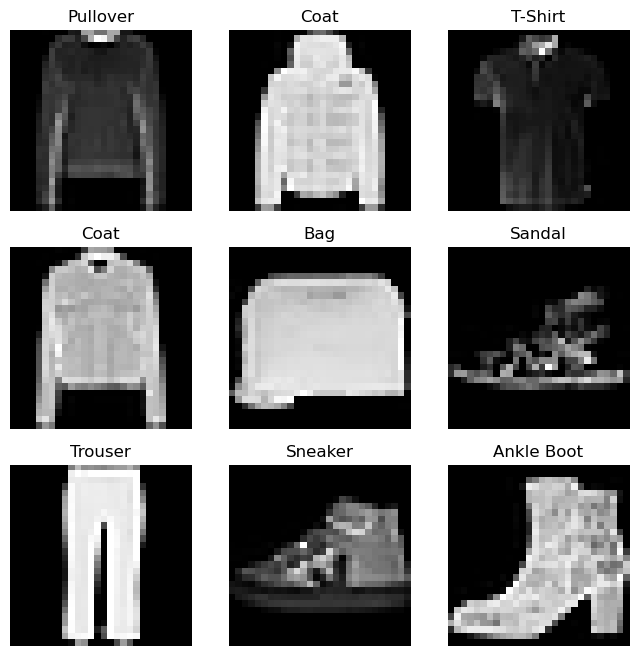

In [64]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Transforms

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we can use ToTensor and Lambda.

`target_transform` defines a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [65]:
%matplotlib inline

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### Defining a network model

Now that we have the test data, define a neural network with 2 hidden layers and ReLU activation functions:

In [66]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Let's break down the steps:
  - initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).
  -  `nn.Linear` is a module that applies a linear transformation on the input using its stored weights and biases.
  -  `nn.ReLU` activations are applied after linear transformations to introduce nonlinearity.
  -  `nn.Sequential` orders the modules.

In order to train a model, we also need to specify a loss function and optimizer:

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Training loop

To sum up, in order to train a model, we need the following:
  - the dataloader that wraps over some dataset
  - model itself (derived from PyTorch's `nn.Module`)
  - loss function
  - optimizer

Needed steps are:
  - compure forward propagation
  - calculate loss
  - compute backward propagation
  - perform GD step

![A picture](./img/training_loop.png)

In [68]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # This just sets the model in train mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We'll also need a test function in order to verify how our model works. Note that we use `torch.no_grad()` as we don't need the gradients when testing:

In [69]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

![A picture](./img/testing_loop.png)

Let's run it:

In [70]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301425  [    0/60000]
loss: 2.292298  [ 6400/60000]
loss: 2.274152  [12800/60000]
loss: 2.268714  [19200/60000]
loss: 2.241956  [25600/60000]
loss: 2.212613  [32000/60000]
loss: 2.234410  [38400/60000]
loss: 2.191838  [44800/60000]
loss: 2.191964  [51200/60000]
loss: 2.158191  [57600/60000]
Test Error: 
 Accuracy: 41.0%, Avg loss: 2.156816 

Epoch 2
-------------------------------
loss: 2.168249  [    0/60000]
loss: 2.160733  [ 6400/60000]
loss: 2.102506  [12800/60000]
loss: 2.111277  [19200/60000]
loss: 2.061579  [25600/60000]
loss: 2.000938  [32000/60000]
loss: 2.044904  [38400/60000]
loss: 1.957663  [44800/60000]
loss: 1.964064  [51200/60000]
loss: 1.888925  [57600/60000]
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.887916 

Epoch 3
-------------------------------
loss: 1.924680  [    0/60000]
loss: 1.895654  [ 6400/60000]
loss: 1.774879  [12800/60000]
loss: 1.807115  [19200/60000]
loss: 1.705418  [25600/60000]
loss: 1.651404  [32000/600

Save and load model:

In [71]:
torch.save(model.state_dict(), "model.pth")
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Let's use the model to make predictions:

In [72]:

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Switch model to evaluation mode
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#  LAB 5

### Tensors

1. Make a tensor of size (2, 17)
2. Make a torch.FloatTensor of size (3, 1)
3. Make a torch.LongTensor of size (5, 2, 1)
  - fill the entire tensor with 7s
4. Make a torch.ByteTensor of size (5,)
  - fill the middle 3 indices with ones such that it records [0, 1, 1, 1, 0]
5. Perform a matrix multiplication of two tensors of size (2, 4) and (4, 2). Then do it in-place.
6. Do element-wise multiplication of two randomly filled $(n_1,n_2,n_3)$ tensors. Then store the result in an Numpy array.

### Forward-prop/backward-prop
1. Create a Tensor that `requires_grad` of size (5, 5).
2. Sum the values in the Tensor.
3. Multiply the tensor by 2 and assign the result to a new python variable (i.e. `x = result`)
4. Sum the variable's elements and assign to a new python variable
5. Print the gradients of all the variables
6. Now perform a backward pass on the last variable (NOTE: for each new python variable that you define, call `.retain_grad()`)
7. Print all gradients again

### Deep-forward NNs
1. Use dl_lab2. In Exercise 12 there, you had to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Reimplement the manual code in PyTorch.
2. Compare test accuracy using different optimizers: SGD, Adam, Momentum.

In [90]:
tensor1 = torch.Tensor(2, 17)

In [91]:
tensor2 = torch.FloatTensor(3, 1)

In [92]:
tensor3 = torch.LongTensor(5, 2, 1).fill_(7)

In [93]:
tensor4 = torch.ByteTensor([0,1,1,1,0])

In [94]:
tensor5a = torch.Tensor(2,4)
tensor5b = torch.Tensor(4,2)
tensor5 = tensor5a.matmul(tensor5b)

In [95]:
n1, n2, n3 = 2, 3, 4
tensor6a = torch.randn(n1, n2, n3)
tensor6b = torch.randn(n1, n2, n3)
tensor6 = tensor6a * tensor6b
numpy_result6 = tensor6.numpy()


In [120]:
tensor = torch.Tensor(5, 5).requires_grad_(True)

In [121]:
sum_tensor = torch.sum(tensor)

In [122]:
x = tensor*2

In [123]:
sum_x = torch.sum(x)
x.retain_grad()

In [124]:
print("Gradients before backward pass:")
print("tensor.grad:", tensor.grad)
print("x.grad:", x.grad)

Gradients before backward pass:
tensor.grad: None
x.grad: None


In [125]:
sum_x.backward()


In [126]:
print("\nGradients after backward pass:")
print("tensor.grad:", tensor.grad)
print("x.grad:", x.grad)


Gradients after backward pass:
tensor.grad: tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]])
x.grad: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [127]:
from dnn_utils import load_data
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [128]:
# Reshape the training and test 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)  # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

#to have feature values between 0 and 1.
train_x = train_x_flatten/255.
train_y = train_y.T
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (209, 12288)
test_x's shape: (50, 12288)


In [148]:
import torch
import torch.nn as nn

class Lab2(nn.Module):
    def __init__(self, num_layers, p_dropout):
        super(Lab2, self).__init__()

        self.fc_input = nn.Linear(12288, 50)
        self.fc_intermediate = nn.ModuleList([nn.Linear(50, 50) for i in range(num_layers-2)])
        self.fc_output = nn.Linear(50, 1)

        self.act_relu = nn.ReLU()
        self.act_sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, x):
        x = self.fc_input(x)
        x = self.act_relu(x)
        x = self.dropout(x)

        for layer in self.fc_intermediate:
            x = layer(x)
            x = self.act_relu(x)
            x = self.dropout(x)

        x = self.fc_output(x)
        x = self.act_sigmoid(x)
        return x


In [145]:
train_loader = torch.utils.data.DataLoader(list(zip(train_x, train_y)), batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(test_x, test_y)), batch_size=256, shuffle=False)

In [146]:
import tqdm
from tqdm.auto import tqdm

def train(model, loader, criterion, optimizer, num_epoch):
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        for X_batch, y_batch in loader:
            X_batch = X_batch.float()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
        
        print(f"Epoch {t+1}, Loss: {np.mean(epoch_loss)}")

    return model


In [149]:
model = Lab2(4, 0)
train(model=model, loader=train_loader, criterion=torch.nn.BCELoss(), optimizer=torch.optim.SGD(model.parameters(), lr=0.005), num_epoch=3500)


  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch 1, Loss: 0.683067262172699
Epoch 2, Loss: 0.6823042035102844
Epoch 3, Loss: 0.6815925240516663
Epoch 4, Loss: 0.6809282302856445
Epoch 5, Loss: 0.6803650259971619
Epoch 6, Loss: 0.6798955798149109
Epoch 7, Loss: 0.6794644594192505
Epoch 8, Loss: 0.6790640354156494
Epoch 9, Loss: 0.6786900758743286
Epoch 10, Loss: 0.678305447101593
Epoch 11, Loss: 0.6778942346572876
Epoch 12, Loss: 0.6774680614471436
Epoch 13, Loss: 0.6770369410514832
Epoch 14, Loss: 0.676541268825531
Epoch 15, Loss: 0.6759910583496094
Epoch 16, Loss: 0.6754526495933533
Epoch 17, Loss: 0.6749258637428284
Epoch 18, Loss: 0.674433708190918
Epoch 19, Loss: 0.6739577054977417
Epoch 20, Loss: 0.6734488010406494
Epoch 21, Loss: 0.6729304790496826
Epoch 22, Loss: 0.6724502444267273
Epoch 23, Loss: 0.6720010042190552
Epoch 24, Loss: 0.6715660095214844
Epoch 25, Loss: 0.6711321473121643
Epoch 26, Loss: 0.6707004904747009
Epoch 27, Loss: 0.6702725291252136
Epoch 28, Loss: 0.669858455657959
Epoch 29, Loss: 0.6694450378417969

Epoch 238, Loss: 0.6406946778297424
Epoch 239, Loss: 0.6406435966491699
Epoch 240, Loss: 0.6405927538871765
Epoch 241, Loss: 0.640541672706604
Epoch 242, Loss: 0.6404908299446106
Epoch 243, Loss: 0.640440046787262
Epoch 244, Loss: 0.6403892040252686
Epoch 245, Loss: 0.6403382420539856
Epoch 246, Loss: 0.6402868032455444
Epoch 247, Loss: 0.6402355432510376
Epoch 248, Loss: 0.640184223651886
Epoch 249, Loss: 0.6401330828666687
Epoch 250, Loss: 0.6400818228721619
Epoch 251, Loss: 0.6400304436683655
Epoch 252, Loss: 0.6399782299995422
Epoch 253, Loss: 0.6399263143539429
Epoch 254, Loss: 0.6398744583129883
Epoch 255, Loss: 0.6398227214813232
Epoch 256, Loss: 0.6397711634635925
Epoch 257, Loss: 0.6397192478179932
Epoch 258, Loss: 0.6396671533584595
Epoch 259, Loss: 0.6396145820617676
Epoch 260, Loss: 0.6395620703697205
Epoch 261, Loss: 0.6395100355148315
Epoch 262, Loss: 0.6394577622413635
Epoch 263, Loss: 0.6394051909446716
Epoch 264, Loss: 0.6393517851829529
Epoch 265, Loss: 0.639296889305

Epoch 471, Loss: 0.6239973902702332
Epoch 472, Loss: 0.6238916516304016
Epoch 473, Loss: 0.623787522315979
Epoch 474, Loss: 0.6236811876296997
Epoch 475, Loss: 0.6235748529434204
Epoch 476, Loss: 0.6234689354896545
Epoch 477, Loss: 0.6233620047569275
Epoch 478, Loss: 0.6232547760009766
Epoch 479, Loss: 0.6231474876403809
Epoch 480, Loss: 0.6230390667915344
Epoch 481, Loss: 0.622930109500885
Epoch 482, Loss: 0.6228212118148804
Epoch 483, Loss: 0.6227138638496399
Epoch 484, Loss: 0.622606635093689
Epoch 485, Loss: 0.6224995255470276
Epoch 486, Loss: 0.6223909854888916
Epoch 487, Loss: 0.6222826838493347
Epoch 488, Loss: 0.6221742630004883
Epoch 489, Loss: 0.6220663785934448
Epoch 490, Loss: 0.6219577789306641
Epoch 491, Loss: 0.621849536895752
Epoch 492, Loss: 0.6217405796051025
Epoch 493, Loss: 0.6216323971748352
Epoch 494, Loss: 0.6215231418609619
Epoch 495, Loss: 0.6214136481285095
Epoch 496, Loss: 0.6213041543960571
Epoch 497, Loss: 0.6211944222450256
Epoch 498, Loss: 0.6210823059082

Epoch 709, Loss: 0.5867651104927063
Epoch 710, Loss: 0.5865653157234192
Epoch 711, Loss: 0.5863571763038635
Epoch 712, Loss: 0.5861542820930481
Epoch 713, Loss: 0.5859522223472595
Epoch 714, Loss: 0.5857495069503784
Epoch 715, Loss: 0.585541307926178
Epoch 716, Loss: 0.5853359699249268
Epoch 717, Loss: 0.585129976272583
Epoch 718, Loss: 0.5849260091781616
Epoch 719, Loss: 0.5847200751304626
Epoch 720, Loss: 0.5845203995704651
Epoch 721, Loss: 0.5843084454536438
Epoch 722, Loss: 0.5841076374053955
Epoch 723, Loss: 0.5838995575904846
Epoch 724, Loss: 0.5836951732635498
Epoch 725, Loss: 0.5834836959838867
Epoch 726, Loss: 0.5832781195640564
Epoch 727, Loss: 0.5830659866333008
Epoch 728, Loss: 0.5828588008880615
Epoch 729, Loss: 0.5826456546783447
Epoch 730, Loss: 0.5824430584907532
Epoch 731, Loss: 0.5822195410728455
Epoch 732, Loss: 0.5820066928863525
Epoch 733, Loss: 0.5817954540252686
Epoch 734, Loss: 0.5815889239311218
Epoch 735, Loss: 0.5813660621643066
Epoch 736, Loss: 0.58115231990

Epoch 947, Loss: 0.5216672420501709
Epoch 948, Loss: 0.5213042497634888
Epoch 949, Loss: 0.5209348201751709
Epoch 950, Loss: 0.5205616354942322
Epoch 951, Loss: 0.5201948881149292
Epoch 952, Loss: 0.5198323130607605
Epoch 953, Loss: 0.5194581747055054
Epoch 954, Loss: 0.5190771222114563
Epoch 955, Loss: 0.5187081694602966
Epoch 956, Loss: 0.5183362364768982
Epoch 957, Loss: 0.5179672241210938
Epoch 958, Loss: 0.5175957679748535
Epoch 959, Loss: 0.5172252655029297
Epoch 960, Loss: 0.5168378353118896
Epoch 961, Loss: 0.5164635181427002
Epoch 962, Loss: 0.5160739421844482
Epoch 963, Loss: 0.5157000422477722
Epoch 964, Loss: 0.5153077840805054
Epoch 965, Loss: 0.5149335265159607
Epoch 966, Loss: 0.5145437121391296
Epoch 967, Loss: 0.5141591429710388
Epoch 968, Loss: 0.5137811899185181
Epoch 969, Loss: 0.5133896470069885
Epoch 970, Loss: 0.5130086541175842
Epoch 971, Loss: 0.5126221776008606
Epoch 972, Loss: 0.5122327208518982
Epoch 973, Loss: 0.5118246674537659
Epoch 974, Loss: 0.511435389

Epoch 1175, Loss: 0.4121280610561371
Epoch 1176, Loss: 0.41152873635292053
Epoch 1177, Loss: 0.4109232425689697
Epoch 1178, Loss: 0.4103833734989166
Epoch 1179, Loss: 0.40981757640838623
Epoch 1180, Loss: 0.40926504135131836
Epoch 1181, Loss: 0.4086442291736603
Epoch 1182, Loss: 0.40812498331069946
Epoch 1183, Loss: 0.4074760973453522
Epoch 1184, Loss: 0.40690627694129944
Epoch 1185, Loss: 0.4062642753124237
Epoch 1186, Loss: 0.4056383967399597
Epoch 1187, Loss: 0.4050370454788208
Epoch 1188, Loss: 0.4044206142425537
Epoch 1189, Loss: 0.403811514377594
Epoch 1190, Loss: 0.4031948447227478
Epoch 1191, Loss: 0.4025815427303314
Epoch 1192, Loss: 0.4019656777381897
Epoch 1193, Loss: 0.40135374665260315
Epoch 1194, Loss: 0.40074843168258667
Epoch 1195, Loss: 0.4001481235027313
Epoch 1196, Loss: 0.3995499610900879
Epoch 1197, Loss: 0.39895933866500854
Epoch 1198, Loss: 0.3983883559703827
Epoch 1199, Loss: 0.397814005613327
Epoch 1200, Loss: 0.3972369432449341
Epoch 1201, Loss: 0.396684199571

Epoch 1410, Loss: 0.350260466337204
Epoch 1411, Loss: 0.3407667577266693
Epoch 1412, Loss: 0.34926047921180725
Epoch 1413, Loss: 0.3404100835323334
Epoch 1414, Loss: 0.34813550114631653
Epoch 1415, Loss: 0.33944717049598694
Epoch 1416, Loss: 0.34815514087677
Epoch 1417, Loss: 0.34037524461746216
Epoch 1418, Loss: 0.34808483719825745
Epoch 1419, Loss: 0.3388518691062927
Epoch 1420, Loss: 0.3468945026397705
Epoch 1421, Loss: 0.33689144253730774
Epoch 1422, Loss: 0.34436294436454773
Epoch 1423, Loss: 0.33570289611816406
Epoch 1424, Loss: 0.34283044934272766
Epoch 1425, Loss: 0.3345392644405365
Epoch 1426, Loss: 0.34205299615859985
Epoch 1427, Loss: 0.33402299880981445
Epoch 1428, Loss: 0.3417559266090393
Epoch 1429, Loss: 0.33456021547317505
Epoch 1430, Loss: 0.34185338020324707
Epoch 1431, Loss: 0.33390742540359497
Epoch 1432, Loss: 0.3422497510910034
Epoch 1433, Loss: 0.3352832794189453
Epoch 1434, Loss: 0.3432232737541199
Epoch 1435, Loss: 0.335117369890213
Epoch 1436, Loss: 0.34398570

Epoch 1642, Loss: 0.27933061122894287
Epoch 1643, Loss: 0.2810719609260559
Epoch 1644, Loss: 0.27898308634757996
Epoch 1645, Loss: 0.28069308400154114
Epoch 1646, Loss: 0.2769624888896942
Epoch 1647, Loss: 0.27751633524894714
Epoch 1648, Loss: 0.27406129240989685
Epoch 1649, Loss: 0.27701064944267273
Epoch 1650, Loss: 0.2730855345726013
Epoch 1651, Loss: 0.2741754949092865
Epoch 1652, Loss: 0.2713630497455597
Epoch 1653, Loss: 0.27450770139694214
Epoch 1654, Loss: 0.27168941497802734
Epoch 1655, Loss: 0.2733208239078522
Epoch 1656, Loss: 0.2697506844997406
Epoch 1657, Loss: 0.2725262939929962
Epoch 1658, Loss: 0.2682865560054779
Epoch 1659, Loss: 0.269976407289505
Epoch 1660, Loss: 0.26904237270355225
Epoch 1661, Loss: 0.2731655240058899
Epoch 1662, Loss: 0.2730206847190857
Epoch 1663, Loss: 0.27571025490760803
Epoch 1664, Loss: 0.2727110683917999
Epoch 1665, Loss: 0.2745741009712219
Epoch 1666, Loss: 0.27390003204345703
Epoch 1667, Loss: 0.27068081498146057
Epoch 1668, Loss: 0.2719412

Epoch 1864, Loss: 0.11818278580904007
Epoch 1865, Loss: 0.11825752258300781
Epoch 1866, Loss: 0.11679697036743164
Epoch 1867, Loss: 0.11844558268785477
Epoch 1868, Loss: 0.11729759722948074
Epoch 1869, Loss: 0.1194993406534195
Epoch 1870, Loss: 0.11801176518201828
Epoch 1871, Loss: 0.12108898907899857
Epoch 1872, Loss: 0.11949232220649719
Epoch 1873, Loss: 0.12275778502225876
Epoch 1874, Loss: 0.12068785727024078
Epoch 1875, Loss: 0.12433020025491714
Epoch 1876, Loss: 0.12259555608034134
Epoch 1877, Loss: 0.12737849354743958
Epoch 1878, Loss: 0.12286308407783508
Epoch 1879, Loss: 0.1270129382610321
Epoch 1880, Loss: 0.12336739152669907
Epoch 1881, Loss: 0.12846656143665314
Epoch 1882, Loss: 0.12189872562885284
Epoch 1883, Loss: 0.1243077889084816
Epoch 1884, Loss: 0.11861593276262283
Epoch 1885, Loss: 0.12019288539886475
Epoch 1886, Loss: 0.115871861577034
Epoch 1887, Loss: 0.11838549375534058
Epoch 1888, Loss: 0.1150464117527008
Epoch 1889, Loss: 0.1179770901799202
Epoch 1890, Loss: 0

Epoch 2084, Loss: 0.05872172862291336
Epoch 2085, Loss: 0.05854561924934387
Epoch 2086, Loss: 0.058288127183914185
Epoch 2087, Loss: 0.058122120797634125
Epoch 2088, Loss: 0.05800061300396919
Epoch 2089, Loss: 0.057793695479631424
Epoch 2090, Loss: 0.05754879489541054
Epoch 2091, Loss: 0.05738135054707527
Epoch 2092, Loss: 0.05718543380498886
Epoch 2093, Loss: 0.05702081695199013
Epoch 2094, Loss: 0.05683848261833191
Epoch 2095, Loss: 0.0566621758043766
Epoch 2096, Loss: 0.05639548972249031
Epoch 2097, Loss: 0.05624348670244217
Epoch 2098, Loss: 0.056159209460020065
Epoch 2099, Loss: 0.055938199162483215
Epoch 2100, Loss: 0.05568091943860054
Epoch 2101, Loss: 0.05550742149353027
Epoch 2102, Loss: 0.05535223335027695
Epoch 2103, Loss: 0.05518815666437149
Epoch 2104, Loss: 0.05495239049196243
Epoch 2105, Loss: 0.05476447939872742
Epoch 2106, Loss: 0.05456534028053284
Epoch 2107, Loss: 0.05437108501791954
Epoch 2108, Loss: 0.05417109653353691
Epoch 2109, Loss: 0.053996145725250244
Epoch 2

Epoch 2302, Loss: 0.03243132680654526
Epoch 2303, Loss: 0.032373517751693726
Epoch 2304, Loss: 0.03228206932544708
Epoch 2305, Loss: 0.03219273313879967
Epoch 2306, Loss: 0.03213978186249733
Epoch 2307, Loss: 0.03206368163228035
Epoch 2308, Loss: 0.03198274224996567
Epoch 2309, Loss: 0.03189601004123688
Epoch 2310, Loss: 0.03184209764003754
Epoch 2311, Loss: 0.03177344799041748
Epoch 2312, Loss: 0.031682807952165604
Epoch 2313, Loss: 0.031605616211891174
Epoch 2314, Loss: 0.03155713900923729
Epoch 2315, Loss: 0.03146381676197052
Epoch 2316, Loss: 0.03139350190758705
Epoch 2317, Loss: 0.03129221498966217
Epoch 2318, Loss: 0.03121754340827465
Epoch 2319, Loss: 0.031133374199271202
Epoch 2320, Loss: 0.031067408621311188
Epoch 2321, Loss: 0.030988235026597977
Epoch 2322, Loss: 0.03092644363641739
Epoch 2323, Loss: 0.03085367940366268
Epoch 2324, Loss: 0.030789503827691078
Epoch 2325, Loss: 0.030711734667420387
Epoch 2326, Loss: 0.03067784011363983
Epoch 2327, Loss: 0.03058467246592045
Epoc

Epoch 2528, Loss: 0.020229680463671684
Epoch 2529, Loss: 0.02018493041396141
Epoch 2530, Loss: 0.02014928124845028
Epoch 2531, Loss: 0.02010943740606308
Epoch 2532, Loss: 0.020073343068361282
Epoch 2533, Loss: 0.020038176327943802
Epoch 2534, Loss: 0.019995272159576416
Epoch 2535, Loss: 0.019957583397626877
Epoch 2536, Loss: 0.019926892593503
Epoch 2537, Loss: 0.019894849509000778
Epoch 2538, Loss: 0.019853878766298294
Epoch 2539, Loss: 0.019818050786852837
Epoch 2540, Loss: 0.01978236809372902
Epoch 2541, Loss: 0.019745856523513794
Epoch 2542, Loss: 0.01970725506544113
Epoch 2543, Loss: 0.01966702751815319
Epoch 2544, Loss: 0.019646449014544487
Epoch 2545, Loss: 0.019606785848736763
Epoch 2546, Loss: 0.019568219780921936
Epoch 2547, Loss: 0.019528182223439217
Epoch 2548, Loss: 0.019495468586683273
Epoch 2549, Loss: 0.01946188509464264
Epoch 2550, Loss: 0.01942935213446617
Epoch 2551, Loss: 0.01939382031559944
Epoch 2552, Loss: 0.01936778984963894
Epoch 2553, Loss: 0.019326932728290558

Epoch 2744, Loss: 0.014092333614826202
Epoch 2745, Loss: 0.014067167416214943
Epoch 2746, Loss: 0.01404921431094408
Epoch 2747, Loss: 0.014034401625394821
Epoch 2748, Loss: 0.014005571603775024
Epoch 2749, Loss: 0.013983065262436867
Epoch 2750, Loss: 0.013966058380901814
Epoch 2751, Loss: 0.013942667283117771
Epoch 2752, Loss: 0.01392174232751131
Epoch 2753, Loss: 0.013899574987590313
Epoch 2754, Loss: 0.013879277743399143
Epoch 2755, Loss: 0.01386035606265068
Epoch 2756, Loss: 0.013841407373547554
Epoch 2757, Loss: 0.013813852332532406
Epoch 2758, Loss: 0.013797860592603683
Epoch 2759, Loss: 0.013774273917078972
Epoch 2760, Loss: 0.01375223696231842
Epoch 2761, Loss: 0.013737328350543976
Epoch 2762, Loss: 0.013712907209992409
Epoch 2763, Loss: 0.013697832822799683
Epoch 2764, Loss: 0.013673486188054085
Epoch 2765, Loss: 0.013651421293616295
Epoch 2766, Loss: 0.013635036535561085
Epoch 2767, Loss: 0.013609613291919231
Epoch 2768, Loss: 0.013590923510491848
Epoch 2769, Loss: 0.013574934

Epoch 2958, Loss: 0.010474766604602337
Epoch 2959, Loss: 0.010462870821356773
Epoch 2960, Loss: 0.010453496128320694
Epoch 2961, Loss: 0.010436534881591797
Epoch 2962, Loss: 0.010421870276331902
Epoch 2963, Loss: 0.010409699752926826
Epoch 2964, Loss: 0.010398450307548046
Epoch 2965, Loss: 0.010383295826613903
Epoch 2966, Loss: 0.010370936244726181
Epoch 2967, Loss: 0.010359846986830235
Epoch 2968, Loss: 0.010344398207962513
Epoch 2969, Loss: 0.010333647951483727
Epoch 2970, Loss: 0.010320745408535004
Epoch 2971, Loss: 0.010306138545274734
Epoch 2972, Loss: 0.01029334869235754
Epoch 2973, Loss: 0.010281695052981377
Epoch 2974, Loss: 0.010265963152050972
Epoch 2975, Loss: 0.01025396678596735
Epoch 2976, Loss: 0.010242167860269547
Epoch 2977, Loss: 0.010228113271296024
Epoch 2978, Loss: 0.010214279405772686
Epoch 2979, Loss: 0.010203626938164234
Epoch 2980, Loss: 0.010189874097704887
Epoch 2981, Loss: 0.010178809985518456
Epoch 2982, Loss: 0.01016567088663578
Epoch 2983, Loss: 0.01015361

Epoch 3175, Loss: 0.008128955028951168
Epoch 3176, Loss: 0.008118311874568462
Epoch 3177, Loss: 0.008108997717499733
Epoch 3178, Loss: 0.00810201931744814
Epoch 3179, Loss: 0.00809278804808855
Epoch 3180, Loss: 0.008083715103566647
Epoch 3181, Loss: 0.008075173012912273
Epoch 3182, Loss: 0.008065557107329369
Epoch 3183, Loss: 0.00805610977113247
Epoch 3184, Loss: 0.008049314841628075
Epoch 3185, Loss: 0.008039589039981365
Epoch 3186, Loss: 0.008030857890844345
Epoch 3187, Loss: 0.008022654801607132
Epoch 3188, Loss: 0.008015445433557034
Epoch 3189, Loss: 0.008004993200302124
Epoch 3190, Loss: 0.00799656379967928
Epoch 3191, Loss: 0.007990888319909573
Epoch 3192, Loss: 0.007980690337717533
Epoch 3193, Loss: 0.0079716257750988
Epoch 3194, Loss: 0.007964173331856728
Epoch 3195, Loss: 0.007954665459692478
Epoch 3196, Loss: 0.007947377860546112
Epoch 3197, Loss: 0.007938245311379433
Epoch 3198, Loss: 0.007928989827632904
Epoch 3199, Loss: 0.007921084761619568
Epoch 3200, Loss: 0.00791073497

Epoch 3386, Loss: 0.0065710460767149925
Epoch 3387, Loss: 0.006565465126186609
Epoch 3388, Loss: 0.006558142602443695
Epoch 3389, Loss: 0.0065513248555362225
Epoch 3390, Loss: 0.006547075696289539
Epoch 3391, Loss: 0.006538700312376022
Epoch 3392, Loss: 0.00653397012501955
Epoch 3393, Loss: 0.00652853399515152
Epoch 3394, Loss: 0.0065208012238144875
Epoch 3395, Loss: 0.0065158638171851635
Epoch 3396, Loss: 0.006509533151984215
Epoch 3397, Loss: 0.006503397598862648
Epoch 3398, Loss: 0.006496494635939598
Epoch 3399, Loss: 0.0064928303472697735
Epoch 3400, Loss: 0.006485703866928816
Epoch 3401, Loss: 0.006479842122644186
Epoch 3402, Loss: 0.006473510526120663
Epoch 3403, Loss: 0.006466724444180727
Epoch 3404, Loss: 0.006461916957050562
Epoch 3405, Loss: 0.00645428104326129
Epoch 3406, Loss: 0.0064492132514715195
Epoch 3407, Loss: 0.006443607155233622
Epoch 3408, Loss: 0.006436080671846867
Epoch 3409, Loss: 0.0064307162538170815
Epoch 3410, Loss: 0.006425425410270691
Epoch 3411, Loss: 0.0

Lab2(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0, inplace=False)
)

In [150]:
import numpy as np
from sklearn.metrics import accuracy_score

with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

# Конвертуємо ймовірності прогнозів у класові мітки (0 або 1) за порогом 0.5
nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])

test_y_flattened = test_y.T.flatten()

accuracy = accuracy_score(test_y_flattened, nn_prediction)

print("Точність:", accuracy)


Точність: 0.74


In [151]:
model = Lab2(4, 0)
train(model=model, loader=train_loader, criterion=torch.nn.BCELoss(), optimizer=torch.optim.SGD(model.parameters(), lr=0.005), num_epoch=4000)


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 1, Loss: 0.6880459785461426
Epoch 2, Loss: 0.6876206398010254
Epoch 3, Loss: 0.6872110366821289
Epoch 4, Loss: 0.6867966651916504
Epoch 5, Loss: 0.6863861680030823
Epoch 6, Loss: 0.6859870553016663
Epoch 7, Loss: 0.6855860352516174
Epoch 8, Loss: 0.6851410269737244
Epoch 9, Loss: 0.6847008466720581
Epoch 10, Loss: 0.6842761039733887
Epoch 11, Loss: 0.6838489174842834
Epoch 12, Loss: 0.683427631855011
Epoch 13, Loss: 0.6830029487609863
Epoch 14, Loss: 0.6825755834579468
Epoch 15, Loss: 0.6821438670158386
Epoch 16, Loss: 0.681719958782196
Epoch 17, Loss: 0.6812968254089355
Epoch 18, Loss: 0.680867612361908
Epoch 19, Loss: 0.6804449558258057
Epoch 20, Loss: 0.6800342202186584
Epoch 21, Loss: 0.6796472072601318
Epoch 22, Loss: 0.6792575716972351
Epoch 23, Loss: 0.6788811683654785
Epoch 24, Loss: 0.6785129308700562
Epoch 25, Loss: 0.6781543493270874
Epoch 26, Loss: 0.6777946352958679
Epoch 27, Loss: 0.67743980884552
Epoch 28, Loss: 0.6770882606506348
Epoch 29, Loss: 0.6767445206642151

Epoch 239, Loss: 0.6429643630981445
Epoch 240, Loss: 0.6429004669189453
Epoch 241, Loss: 0.6428359746932983
Epoch 242, Loss: 0.6427707076072693
Epoch 243, Loss: 0.642703652381897
Epoch 244, Loss: 0.6426384449005127
Epoch 245, Loss: 0.6425744295120239
Epoch 246, Loss: 0.6425110101699829
Epoch 247, Loss: 0.6424472332000732
Epoch 248, Loss: 0.6423845291137695
Epoch 249, Loss: 0.6423222422599792
Epoch 250, Loss: 0.6422593593597412
Epoch 251, Loss: 0.6421969532966614
Epoch 252, Loss: 0.6421322822570801
Epoch 253, Loss: 0.6420658826828003
Epoch 254, Loss: 0.6420003175735474
Epoch 255, Loss: 0.6419313549995422
Epoch 256, Loss: 0.6418625712394714
Epoch 257, Loss: 0.6417936682701111
Epoch 258, Loss: 0.641727864742279
Epoch 259, Loss: 0.6416615843772888
Epoch 260, Loss: 0.6415963768959045
Epoch 261, Loss: 0.641531229019165
Epoch 262, Loss: 0.6414669156074524
Epoch 263, Loss: 0.6414032578468323
Epoch 264, Loss: 0.6413404941558838
Epoch 265, Loss: 0.6412777900695801
Epoch 266, Loss: 0.641214191913

Epoch 468, Loss: 0.6236994862556458
Epoch 469, Loss: 0.6235780119895935
Epoch 470, Loss: 0.6234562993049622
Epoch 471, Loss: 0.6233347654342651
Epoch 472, Loss: 0.623212993144989
Epoch 473, Loss: 0.6230908036231995
Epoch 474, Loss: 0.6229687333106995
Epoch 475, Loss: 0.6228466033935547
Epoch 476, Loss: 0.6227240562438965
Epoch 477, Loss: 0.6226015686988831
Epoch 478, Loss: 0.6224790215492249
Epoch 479, Loss: 0.6223568916320801
Epoch 480, Loss: 0.6222338676452637
Epoch 481, Loss: 0.6221108436584473
Epoch 482, Loss: 0.6219869256019592
Epoch 483, Loss: 0.6218631267547607
Epoch 484, Loss: 0.6217385530471802
Epoch 485, Loss: 0.6216135025024414
Epoch 486, Loss: 0.621487557888031
Epoch 487, Loss: 0.6213616728782654
Epoch 488, Loss: 0.6212352514266968
Epoch 489, Loss: 0.621108889579773
Epoch 490, Loss: 0.6209824085235596
Epoch 491, Loss: 0.6208553314208984
Epoch 492, Loss: 0.6207281351089478
Epoch 493, Loss: 0.6205992102622986
Epoch 494, Loss: 0.6204710602760315
Epoch 495, Loss: 0.620342373847

Epoch 705, Loss: 0.5795019865036011
Epoch 706, Loss: 0.5792307257652283
Epoch 707, Loss: 0.5789607763290405
Epoch 708, Loss: 0.5786949992179871
Epoch 709, Loss: 0.5784217715263367
Epoch 710, Loss: 0.5781518220901489
Epoch 711, Loss: 0.5778809785842896
Epoch 712, Loss: 0.5776087641716003
Epoch 713, Loss: 0.5773370862007141
Epoch 714, Loss: 0.5770631432533264
Epoch 715, Loss: 0.5767839550971985
Epoch 716, Loss: 0.5765081644058228
Epoch 717, Loss: 0.5762346386909485
Epoch 718, Loss: 0.5759603977203369
Epoch 719, Loss: 0.5756780505180359
Epoch 720, Loss: 0.5754064321517944
Epoch 721, Loss: 0.5751226544380188
Epoch 722, Loss: 0.5748453736305237
Epoch 723, Loss: 0.5745634436607361
Epoch 724, Loss: 0.5742805600166321
Epoch 725, Loss: 0.5739966034889221
Epoch 726, Loss: 0.5737135410308838
Epoch 727, Loss: 0.5734294652938843
Epoch 728, Loss: 0.5731463432312012
Epoch 729, Loss: 0.5728552937507629
Epoch 730, Loss: 0.5725703835487366
Epoch 731, Loss: 0.572279691696167
Epoch 732, Loss: 0.5719880461

Epoch 937, Loss: 0.49003854393959045
Epoch 938, Loss: 0.48954081535339355
Epoch 939, Loss: 0.489045649766922
Epoch 940, Loss: 0.48854097723960876
Epoch 941, Loss: 0.4880339205265045
Epoch 942, Loss: 0.48752561211586
Epoch 943, Loss: 0.4870278835296631
Epoch 944, Loss: 0.48650923371315
Epoch 945, Loss: 0.48600706458091736
Epoch 946, Loss: 0.48548591136932373
Epoch 947, Loss: 0.48498547077178955
Epoch 948, Loss: 0.48445847630500793
Epoch 949, Loss: 0.4839552044868469
Epoch 950, Loss: 0.48343849182128906
Epoch 951, Loss: 0.48291394114494324
Epoch 952, Loss: 0.48240187764167786
Epoch 953, Loss: 0.48188215494155884
Epoch 954, Loss: 0.481367826461792
Epoch 955, Loss: 0.4808424413204193
Epoch 956, Loss: 0.4803239107131958
Epoch 957, Loss: 0.47979462146759033
Epoch 958, Loss: 0.4792806804180145
Epoch 959, Loss: 0.47874483466148376
Epoch 960, Loss: 0.4782215356826782
Epoch 961, Loss: 0.47769781947135925
Epoch 962, Loss: 0.47717708349227905
Epoch 963, Loss: 0.47665679454803467
Epoch 964, Loss: 0

Epoch 1166, Loss: 0.355284184217453
Epoch 1167, Loss: 0.3546225130558014
Epoch 1168, Loss: 0.35441914200782776
Epoch 1169, Loss: 0.35365861654281616
Epoch 1170, Loss: 0.3533652126789093
Epoch 1171, Loss: 0.3526562750339508
Epoch 1172, Loss: 0.35253778100013733
Epoch 1173, Loss: 0.3517732322216034
Epoch 1174, Loss: 0.35176458954811096
Epoch 1175, Loss: 0.351008802652359
Epoch 1176, Loss: 0.3508961796760559
Epoch 1177, Loss: 0.3500632047653198
Epoch 1178, Loss: 0.34998658299446106
Epoch 1179, Loss: 0.3490917384624481
Epoch 1180, Loss: 0.34911641478538513
Epoch 1181, Loss: 0.34847190976142883
Epoch 1182, Loss: 0.34869107604026794
Epoch 1183, Loss: 0.34801575541496277
Epoch 1184, Loss: 0.3484438359737396
Epoch 1185, Loss: 0.3477187156677246
Epoch 1186, Loss: 0.34832271933555603
Epoch 1187, Loss: 0.3475757837295532
Epoch 1188, Loss: 0.34814515709877014
Epoch 1189, Loss: 0.3474397659301758
Epoch 1190, Loss: 0.3479638397693634
Epoch 1191, Loss: 0.3473718762397766
Epoch 1192, Loss: 0.348375350

Epoch 1393, Loss: 0.3338238000869751
Epoch 1394, Loss: 0.35298317670822144
Epoch 1395, Loss: 0.3339327871799469
Epoch 1396, Loss: 0.35260751843452454
Epoch 1397, Loss: 0.3333636522293091
Epoch 1398, Loss: 0.35183554887771606
Epoch 1399, Loss: 0.33353060483932495
Epoch 1400, Loss: 0.353238582611084
Epoch 1401, Loss: 0.334360808134079
Epoch 1402, Loss: 0.3531220853328705
Epoch 1403, Loss: 0.334136039018631
Epoch 1404, Loss: 0.35397520661354065
Epoch 1405, Loss: 0.3349344730377197
Epoch 1406, Loss: 0.3532506823539734
Epoch 1407, Loss: 0.33200371265411377
Epoch 1408, Loss: 0.35112953186035156
Epoch 1409, Loss: 0.33281436562538147
Epoch 1410, Loss: 0.35150352120399475
Epoch 1411, Loss: 0.32945993542671204
Epoch 1412, Loss: 0.3467755913734436
Epoch 1413, Loss: 0.32856810092926025
Epoch 1414, Loss: 0.34806933999061584
Epoch 1415, Loss: 0.32684165239334106
Epoch 1416, Loss: 0.3428226113319397
Epoch 1417, Loss: 0.32596737146377563
Epoch 1418, Loss: 0.3443722426891327
Epoch 1419, Loss: 0.3253182

Epoch 1620, Loss: 0.26698461174964905
Epoch 1621, Loss: 0.2551538348197937
Epoch 1622, Loss: 0.2659468948841095
Epoch 1623, Loss: 0.25564655661582947
Epoch 1624, Loss: 0.2665720582008362
Epoch 1625, Loss: 0.2546011507511139
Epoch 1626, Loss: 0.26520130038261414
Epoch 1627, Loss: 0.2550758421421051
Epoch 1628, Loss: 0.2651611864566803
Epoch 1629, Loss: 0.2537067234516144
Epoch 1630, Loss: 0.26580697298049927
Epoch 1631, Loss: 0.2544019818305969
Epoch 1632, Loss: 0.26483526825904846
Epoch 1633, Loss: 0.2540624141693115
Epoch 1634, Loss: 0.2650597095489502
Epoch 1635, Loss: 0.2540823519229889
Epoch 1636, Loss: 0.26537322998046875
Epoch 1637, Loss: 0.2542407810688019
Epoch 1638, Loss: 0.26599520444869995
Epoch 1639, Loss: 0.25538307428359985
Epoch 1640, Loss: 0.2669272720813751
Epoch 1641, Loss: 0.25531208515167236
Epoch 1642, Loss: 0.26744896173477173
Epoch 1643, Loss: 0.2558559775352478
Epoch 1644, Loss: 0.2681593596935272
Epoch 1645, Loss: 0.2582659125328064
Epoch 1646, Loss: 0.27034136

Epoch 1849, Loss: 0.10694962739944458
Epoch 1850, Loss: 0.1061566174030304
Epoch 1851, Loss: 0.1055007129907608
Epoch 1852, Loss: 0.1049395501613617
Epoch 1853, Loss: 0.10446275770664215
Epoch 1854, Loss: 0.10402175784111023
Epoch 1855, Loss: 0.10362272709608078
Epoch 1856, Loss: 0.10323885083198547
Epoch 1857, Loss: 0.10289004445075989
Epoch 1858, Loss: 0.10253626853227615
Epoch 1859, Loss: 0.10219765454530716
Epoch 1860, Loss: 0.10183171182870865
Epoch 1861, Loss: 0.10145897418260574
Epoch 1862, Loss: 0.10109634697437286
Epoch 1863, Loss: 0.10074964910745621
Epoch 1864, Loss: 0.10041359812021255
Epoch 1865, Loss: 0.10010964423418045
Epoch 1866, Loss: 0.09981605410575867
Epoch 1867, Loss: 0.09950803220272064
Epoch 1868, Loss: 0.09922964125871658
Epoch 1869, Loss: 0.0989239513874054
Epoch 1870, Loss: 0.09867464005947113
Epoch 1871, Loss: 0.09836918860673904
Epoch 1872, Loss: 0.09813417494297028
Epoch 1873, Loss: 0.09782730787992477
Epoch 1874, Loss: 0.09760268032550812
Epoch 1875, Loss

Epoch 2068, Loss: 0.056797418743371964
Epoch 2069, Loss: 0.056615136563777924
Epoch 2070, Loss: 0.05650154501199722
Epoch 2071, Loss: 0.05631936341524124
Epoch 2072, Loss: 0.05619719251990318
Epoch 2073, Loss: 0.056009866297245026
Epoch 2074, Loss: 0.05586685240268707
Epoch 2075, Loss: 0.055713407695293427
Epoch 2076, Loss: 0.0555739626288414
Epoch 2077, Loss: 0.055415596812963486
Epoch 2078, Loss: 0.055308401584625244
Epoch 2079, Loss: 0.05511854588985443
Epoch 2080, Loss: 0.0549764409661293
Epoch 2081, Loss: 0.054842591285705566
Epoch 2082, Loss: 0.05471889674663544
Epoch 2083, Loss: 0.05452772229909897
Epoch 2084, Loss: 0.05442582443356514
Epoch 2085, Loss: 0.054248612374067307
Epoch 2086, Loss: 0.05409115180373192
Epoch 2087, Loss: 0.053931716829538345
Epoch 2088, Loss: 0.05380001664161682
Epoch 2089, Loss: 0.0536360889673233
Epoch 2090, Loss: 0.0535171814262867
Epoch 2091, Loss: 0.05337097868323326
Epoch 2092, Loss: 0.053239818662405014
Epoch 2093, Loss: 0.05306287854909897
Epoch 

Epoch 2291, Loss: 0.032404039055109024
Epoch 2292, Loss: 0.03234007582068443
Epoch 2293, Loss: 0.03226276487112045
Epoch 2294, Loss: 0.032192494720220566
Epoch 2295, Loss: 0.03212250396609306
Epoch 2296, Loss: 0.032041244208812714
Epoch 2297, Loss: 0.0319637805223465
Epoch 2298, Loss: 0.031890466809272766
Epoch 2299, Loss: 0.03182021155953407
Epoch 2300, Loss: 0.031753070652484894
Epoch 2301, Loss: 0.031686268746852875
Epoch 2302, Loss: 0.03160810470581055
Epoch 2303, Loss: 0.03153344616293907
Epoch 2304, Loss: 0.0314713716506958
Epoch 2305, Loss: 0.031395457684993744
Epoch 2306, Loss: 0.0313260518014431
Epoch 2307, Loss: 0.03125237673521042
Epoch 2308, Loss: 0.031180892139673233
Epoch 2309, Loss: 0.03111865743994713
Epoch 2310, Loss: 0.031052241101861
Epoch 2311, Loss: 0.030978303402662277
Epoch 2312, Loss: 0.0309172160923481
Epoch 2313, Loss: 0.03084571659564972
Epoch 2314, Loss: 0.030781475827097893
Epoch 2315, Loss: 0.030708299949765205
Epoch 2316, Loss: 0.030648915097117424
Epoch 

Epoch 2513, Loss: 0.020688537508249283
Epoch 2514, Loss: 0.020654253661632538
Epoch 2515, Loss: 0.02061590552330017
Epoch 2516, Loss: 0.020578188821673393
Epoch 2517, Loss: 0.020546702668070793
Epoch 2518, Loss: 0.020500322803854942
Epoch 2519, Loss: 0.02047140896320343
Epoch 2520, Loss: 0.02043021284043789
Epoch 2521, Loss: 0.020394884049892426
Epoch 2522, Loss: 0.020352061837911606
Epoch 2523, Loss: 0.020314816385507584
Epoch 2524, Loss: 0.020280856639146805
Epoch 2525, Loss: 0.020241735503077507
Epoch 2526, Loss: 0.020204592496156693
Epoch 2527, Loss: 0.020170312374830246
Epoch 2528, Loss: 0.020129792392253876
Epoch 2529, Loss: 0.020096633583307266
Epoch 2530, Loss: 0.02006356604397297
Epoch 2531, Loss: 0.020027395337820053
Epoch 2532, Loss: 0.019987961277365685
Epoch 2533, Loss: 0.019961640238761902
Epoch 2534, Loss: 0.01992299035191536
Epoch 2535, Loss: 0.019886165857315063
Epoch 2536, Loss: 0.019846463575959206
Epoch 2537, Loss: 0.01981591433286667
Epoch 2538, Loss: 0.01977309025

Epoch 2728, Loss: 0.014453847892582417
Epoch 2729, Loss: 0.0144309401512146
Epoch 2730, Loss: 0.014413793571293354
Epoch 2731, Loss: 0.01439112238585949
Epoch 2732, Loss: 0.014373596757650375
Epoch 2733, Loss: 0.014346694573760033
Epoch 2734, Loss: 0.01432638056576252
Epoch 2735, Loss: 0.01430425327271223
Epoch 2736, Loss: 0.01428229920566082
Epoch 2737, Loss: 0.014258967712521553
Epoch 2738, Loss: 0.014239863492548466
Epoch 2739, Loss: 0.014217270538210869
Epoch 2740, Loss: 0.014196982607245445
Epoch 2741, Loss: 0.014177275821566582
Epoch 2742, Loss: 0.014153984375298023
Epoch 2743, Loss: 0.014132612384855747
Epoch 2744, Loss: 0.014110587537288666
Epoch 2745, Loss: 0.01409075502306223
Epoch 2746, Loss: 0.01406928151845932
Epoch 2747, Loss: 0.014047151431441307
Epoch 2748, Loss: 0.014032527804374695
Epoch 2749, Loss: 0.014010069891810417
Epoch 2750, Loss: 0.013990310952067375
Epoch 2751, Loss: 0.013967289589345455
Epoch 2752, Loss: 0.013943883590400219
Epoch 2753, Loss: 0.0139254275709

Epoch 2952, Loss: 0.010612591169774532
Epoch 2953, Loss: 0.010599548928439617
Epoch 2954, Loss: 0.010586674325168133
Epoch 2955, Loss: 0.010572977364063263
Epoch 2956, Loss: 0.010558174923062325
Epoch 2957, Loss: 0.010547771118581295
Epoch 2958, Loss: 0.010533666238188744
Epoch 2959, Loss: 0.010523197241127491
Epoch 2960, Loss: 0.01050600130110979
Epoch 2961, Loss: 0.010492977686226368
Epoch 2962, Loss: 0.010479002259671688
Epoch 2963, Loss: 0.010466264560818672
Epoch 2964, Loss: 0.010453705675899982
Epoch 2965, Loss: 0.010438834317028522
Epoch 2966, Loss: 0.01042780838906765
Epoch 2967, Loss: 0.010414233431220055
Epoch 2968, Loss: 0.01040197815746069
Epoch 2969, Loss: 0.010389856994152069
Epoch 2970, Loss: 0.01037594210356474
Epoch 2971, Loss: 0.010362395085394382
Epoch 2972, Loss: 0.01035111490637064
Epoch 2973, Loss: 0.010337489657104015
Epoch 2974, Loss: 0.010323403403162956
Epoch 2975, Loss: 0.010311121121048927
Epoch 2976, Loss: 0.010298443026840687
Epoch 2977, Loss: 0.0102864839

Epoch 3168, Loss: 0.008218340575695038
Epoch 3169, Loss: 0.008209092542529106
Epoch 3170, Loss: 0.008199294097721577
Epoch 3171, Loss: 0.008190172724425793
Epoch 3172, Loss: 0.008180589415133
Epoch 3173, Loss: 0.008171574212610722
Epoch 3174, Loss: 0.008161495439708233
Epoch 3175, Loss: 0.00815350841730833
Epoch 3176, Loss: 0.008143930695950985
Epoch 3177, Loss: 0.008135485462844372
Epoch 3178, Loss: 0.008126026950776577
Epoch 3179, Loss: 0.008116877637803555
Epoch 3180, Loss: 0.008107003755867481
Epoch 3181, Loss: 0.008099347352981567
Epoch 3182, Loss: 0.008089117705821991
Epoch 3183, Loss: 0.008080694824457169
Epoch 3184, Loss: 0.008071563206613064
Epoch 3185, Loss: 0.008062911219894886
Epoch 3186, Loss: 0.008053473196923733
Epoch 3187, Loss: 0.008045299910008907
Epoch 3188, Loss: 0.008035564795136452
Epoch 3189, Loss: 0.008027671836316586
Epoch 3190, Loss: 0.008017830550670624
Epoch 3191, Loss: 0.008010277524590492
Epoch 3192, Loss: 0.008000529371201992
Epoch 3193, Loss: 0.007992633

Epoch 3394, Loss: 0.006499930284917355
Epoch 3395, Loss: 0.006494683679193258
Epoch 3396, Loss: 0.00648903613910079
Epoch 3397, Loss: 0.006482314318418503
Epoch 3398, Loss: 0.006474807392805815
Epoch 3399, Loss: 0.00646951561793685
Epoch 3400, Loss: 0.006462950259447098
Epoch 3401, Loss: 0.006457294803112745
Epoch 3402, Loss: 0.006450603250414133
Epoch 3403, Loss: 0.006444714963436127
Epoch 3404, Loss: 0.006438678130507469
Epoch 3405, Loss: 0.006432376801967621
Epoch 3406, Loss: 0.006425927858799696
Epoch 3407, Loss: 0.00642011035233736
Epoch 3408, Loss: 0.006413581315428019
Epoch 3409, Loss: 0.006407457869499922
Epoch 3410, Loss: 0.00640166224911809
Epoch 3411, Loss: 0.006395046599209309
Epoch 3412, Loss: 0.006388950627297163
Epoch 3413, Loss: 0.006383074447512627
Epoch 3414, Loss: 0.006376666482537985
Epoch 3415, Loss: 0.006370742805302143
Epoch 3416, Loss: 0.006365151610225439
Epoch 3417, Loss: 0.006358841434121132
Epoch 3418, Loss: 0.006353073753416538
Epoch 3419, Loss: 0.006346870

Epoch 3607, Loss: 0.005367842502892017
Epoch 3608, Loss: 0.005363685078918934
Epoch 3609, Loss: 0.005358494818210602
Epoch 3610, Loss: 0.005354858469218016
Epoch 3611, Loss: 0.005350352264940739
Epoch 3612, Loss: 0.005345243960618973
Epoch 3613, Loss: 0.005340625997632742
Epoch 3614, Loss: 0.005337071605026722
Epoch 3615, Loss: 0.005331944674253464
Epoch 3616, Loss: 0.005327323917299509
Epoch 3617, Loss: 0.0053228470496833324
Epoch 3618, Loss: 0.005318355746567249
Epoch 3619, Loss: 0.00531346071511507
Epoch 3620, Loss: 0.005309353582561016
Epoch 3621, Loss: 0.0053048389963805676
Epoch 3622, Loss: 0.005300456192344427
Epoch 3623, Loss: 0.005296125542372465
Epoch 3624, Loss: 0.005291948094964027
Epoch 3625, Loss: 0.0052871196530759335
Epoch 3626, Loss: 0.005283122416585684
Epoch 3627, Loss: 0.005278455093502998
Epoch 3628, Loss: 0.00527428463101387
Epoch 3629, Loss: 0.005270167253911495
Epoch 3630, Loss: 0.0052655660547316074
Epoch 3631, Loss: 0.005261327140033245
Epoch 3632, Loss: 0.005

Epoch 3831, Loss: 0.004493135493248701
Epoch 3832, Loss: 0.004489432089030743
Epoch 3833, Loss: 0.0044862874783575535
Epoch 3834, Loss: 0.0044825575314462185
Epoch 3835, Loss: 0.004479244351387024
Epoch 3836, Loss: 0.0044759176671504974
Epoch 3837, Loss: 0.004472598433494568
Epoch 3838, Loss: 0.004469358362257481
Epoch 3839, Loss: 0.004466647282242775
Epoch 3840, Loss: 0.0044626803137362
Epoch 3841, Loss: 0.004459212068468332
Epoch 3842, Loss: 0.004456404596567154
Epoch 3843, Loss: 0.004453139379620552
Epoch 3844, Loss: 0.004449374508112669
Epoch 3845, Loss: 0.004446343053132296
Epoch 3846, Loss: 0.004442805424332619
Epoch 3847, Loss: 0.004439373966306448
Epoch 3848, Loss: 0.004436260089278221
Epoch 3849, Loss: 0.004433531779795885
Epoch 3850, Loss: 0.004429641645401716
Epoch 3851, Loss: 0.004426201339811087
Epoch 3852, Loss: 0.004423037171363831
Epoch 3853, Loss: 0.004420163109898567
Epoch 3854, Loss: 0.004416806623339653
Epoch 3855, Loss: 0.004413488786667585
Epoch 3856, Loss: 0.0044

Lab2_reborn(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0, inplace=False)
)

In [152]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

# Конвертуємо ймовірності прогнозів у класові мітки (0 або 1) за порогом 0.5
nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])

test_y_flattened = test_y.T.flatten()

accuracy = accuracy_score(test_y_flattened, nn_prediction)

print("Точність:", accuracy)


Точність: 0.74


In [153]:
model = Lab2(4, 0.1)
train(model=model, loader=train_loader, criterion=torch.nn.BCELoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.0001), num_epoch=3500)


  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7194389700889587
Epoch 2, Loss: 0.7099478840827942
Epoch 3, Loss: 0.7025824189186096
Epoch 4, Loss: 0.6965814828872681
Epoch 5, Loss: 0.6915147304534912
Epoch 6, Loss: 0.6864573359489441
Epoch 7, Loss: 0.6775990724563599
Epoch 8, Loss: 0.6775194406509399
Epoch 9, Loss: 0.6762360334396362
Epoch 10, Loss: 0.6616240739822388
Epoch 11, Loss: 0.6731564998626709
Epoch 12, Loss: 0.6660692691802979
Epoch 13, Loss: 0.662710428237915
Epoch 14, Loss: 0.6722057461738586
Epoch 15, Loss: 0.6655559539794922
Epoch 16, Loss: 0.657436728477478
Epoch 17, Loss: 0.665641188621521
Epoch 18, Loss: 0.6619266867637634
Epoch 19, Loss: 0.6686540246009827
Epoch 20, Loss: 0.6622481346130371
Epoch 21, Loss: 0.6630150675773621
Epoch 22, Loss: 0.6739229559898376
Epoch 23, Loss: 0.665986180305481
Epoch 24, Loss: 0.6483563184738159
Epoch 25, Loss: 0.6516463160514832
Epoch 26, Loss: 0.6409610509872437
Epoch 27, Loss: 0.6586138010025024
Epoch 28, Loss: 0.6672313809394836
Epoch 29, Loss: 0.656449019908905

Epoch 237, Loss: 0.28957653045654297
Epoch 238, Loss: 0.3076532781124115
Epoch 239, Loss: 0.3043791949748993
Epoch 240, Loss: 0.30156654119491577
Epoch 241, Loss: 0.2946469485759735
Epoch 242, Loss: 0.2825824022293091
Epoch 243, Loss: 0.2795279920101166
Epoch 244, Loss: 0.2918386459350586
Epoch 245, Loss: 0.28496912121772766
Epoch 246, Loss: 0.27760642766952515
Epoch 247, Loss: 0.293378621339798
Epoch 248, Loss: 0.28221118450164795
Epoch 249, Loss: 0.26408764719963074
Epoch 250, Loss: 0.278036504983902
Epoch 251, Loss: 0.24489125609397888
Epoch 252, Loss: 0.24671554565429688
Epoch 253, Loss: 0.2727431058883667
Epoch 254, Loss: 0.26444411277770996
Epoch 255, Loss: 0.2528057098388672
Epoch 256, Loss: 0.2747601270675659
Epoch 257, Loss: 0.2447129786014557
Epoch 258, Loss: 0.26739227771759033
Epoch 259, Loss: 0.2658391296863556
Epoch 260, Loss: 0.259952187538147
Epoch 261, Loss: 0.2436360865831375
Epoch 262, Loss: 0.25348782539367676
Epoch 263, Loss: 0.24618321657180786
Epoch 264, Loss: 0.

Epoch 461, Loss: 0.03564710170030594
Epoch 462, Loss: 0.052308645099401474
Epoch 463, Loss: 0.05571978539228439
Epoch 464, Loss: 0.05466672405600548
Epoch 465, Loss: 0.04560210555791855
Epoch 466, Loss: 0.06548171490430832
Epoch 467, Loss: 0.03335486352443695
Epoch 468, Loss: 0.06226987764239311
Epoch 469, Loss: 0.05290452018380165
Epoch 470, Loss: 0.05259621888399124
Epoch 471, Loss: 0.04948853701353073
Epoch 472, Loss: 0.04023544490337372
Epoch 473, Loss: 0.045265160501003265
Epoch 474, Loss: 0.043050747364759445
Epoch 475, Loss: 0.029645906761288643
Epoch 476, Loss: 0.05023641511797905
Epoch 477, Loss: 0.04962848499417305
Epoch 478, Loss: 0.03878575190901756
Epoch 479, Loss: 0.051941584795713425
Epoch 480, Loss: 0.05648907274007797
Epoch 481, Loss: 0.03416404873132706
Epoch 482, Loss: 0.03536634147167206
Epoch 483, Loss: 0.05053987354040146
Epoch 484, Loss: 0.04088158905506134
Epoch 485, Loss: 0.03305014967918396
Epoch 486, Loss: 0.036077581346035004
Epoch 487, Loss: 0.0409678220748

Epoch 688, Loss: 0.016257774084806442
Epoch 689, Loss: 0.01594674028456211
Epoch 690, Loss: 0.010840204544365406
Epoch 691, Loss: 0.013236110098659992
Epoch 692, Loss: 0.01292010024189949
Epoch 693, Loss: 0.010837382636964321
Epoch 694, Loss: 0.012367884628474712
Epoch 695, Loss: 0.01902165822684765
Epoch 696, Loss: 0.009852686896920204
Epoch 697, Loss: 0.021054966375231743
Epoch 698, Loss: 0.015977593138813972
Epoch 699, Loss: 0.011504841968417168
Epoch 700, Loss: 0.020758429542183876
Epoch 701, Loss: 0.012731460854411125
Epoch 702, Loss: 0.010848581790924072
Epoch 703, Loss: 0.013891749083995819
Epoch 704, Loss: 0.015206706710159779
Epoch 705, Loss: 0.012411474250257015
Epoch 706, Loss: 0.008491946384310722
Epoch 707, Loss: 0.011574121192097664
Epoch 708, Loss: 0.015233262442052364
Epoch 709, Loss: 0.014784032478928566
Epoch 710, Loss: 0.014935159124433994
Epoch 711, Loss: 0.009874606505036354
Epoch 712, Loss: 0.01741715893149376
Epoch 713, Loss: 0.010011383332312107
Epoch 714, Loss:

Epoch 915, Loss: 0.007372427731752396
Epoch 916, Loss: 0.005409639794379473
Epoch 917, Loss: 0.00904750544577837
Epoch 918, Loss: 0.005704397801309824
Epoch 919, Loss: 0.007549180183559656
Epoch 920, Loss: 0.005505894310772419
Epoch 921, Loss: 0.004088470246642828
Epoch 922, Loss: 0.006301100365817547
Epoch 923, Loss: 0.004465100355446339
Epoch 924, Loss: 0.007477645296603441
Epoch 925, Loss: 0.004752993118017912
Epoch 926, Loss: 0.00957307405769825
Epoch 927, Loss: 0.007773269899189472
Epoch 928, Loss: 0.0038325407076627016
Epoch 929, Loss: 0.005049122963100672
Epoch 930, Loss: 0.004054525401443243
Epoch 931, Loss: 0.006943990010768175
Epoch 932, Loss: 0.008395809680223465
Epoch 933, Loss: 0.0031651558820158243
Epoch 934, Loss: 0.010187353938817978
Epoch 935, Loss: 0.00569611880928278
Epoch 936, Loss: 0.0043470971286296844
Epoch 937, Loss: 0.003648345358669758
Epoch 938, Loss: 0.003143048845231533
Epoch 939, Loss: 0.004063271917402744
Epoch 940, Loss: 0.007346698548644781
Epoch 941, L

Epoch 1138, Loss: 0.003656131913885474
Epoch 1139, Loss: 0.0036818732041865587
Epoch 1140, Loss: 0.0028787485789507627
Epoch 1141, Loss: 0.00906728021800518
Epoch 1142, Loss: 0.008187574334442616
Epoch 1143, Loss: 0.002568540396168828
Epoch 1144, Loss: 0.0023800188209861517
Epoch 1145, Loss: 0.0027547478675842285
Epoch 1146, Loss: 0.002320864237844944
Epoch 1147, Loss: 0.0023635290563106537
Epoch 1148, Loss: 0.005774020217359066
Epoch 1149, Loss: 0.005601557437330484
Epoch 1150, Loss: 0.001861286349594593
Epoch 1151, Loss: 0.0019220112590119243
Epoch 1152, Loss: 0.004779011011123657
Epoch 1153, Loss: 0.004230262245982885
Epoch 1154, Loss: 0.0029350328259170055
Epoch 1155, Loss: 0.002547089010477066
Epoch 1156, Loss: 0.001253893249668181
Epoch 1157, Loss: 0.002028366085141897
Epoch 1158, Loss: 0.003857480827718973
Epoch 1159, Loss: 0.0012144414940848947
Epoch 1160, Loss: 0.0023223748430609703
Epoch 1161, Loss: 0.0019271112978458405
Epoch 1162, Loss: 0.0028449324890971184
Epoch 1163, Los

Epoch 1356, Loss: 0.0019348554778844118
Epoch 1357, Loss: 0.0010510595748201013
Epoch 1358, Loss: 0.0012070145457983017
Epoch 1359, Loss: 0.001014157896861434
Epoch 1360, Loss: 0.0009400415583513677
Epoch 1361, Loss: 0.0013476557796820998
Epoch 1362, Loss: 0.0014766780659556389
Epoch 1363, Loss: 0.002453999826684594
Epoch 1364, Loss: 0.0010482051875442266
Epoch 1365, Loss: 0.0010932616423815489
Epoch 1366, Loss: 0.0031972324941307306
Epoch 1367, Loss: 0.0027003048453480005
Epoch 1368, Loss: 0.0009313432965427637
Epoch 1369, Loss: 0.0011173042003065348
Epoch 1370, Loss: 0.0008023990667425096
Epoch 1371, Loss: 0.0018596224253997207
Epoch 1372, Loss: 0.0030705996323376894
Epoch 1373, Loss: 0.0020204908214509487
Epoch 1374, Loss: 0.0009422099683433771
Epoch 1375, Loss: 0.001569009735248983
Epoch 1376, Loss: 0.000764952099416405
Epoch 1377, Loss: 0.0017229880904778838
Epoch 1378, Loss: 0.0018925440963357687
Epoch 1379, Loss: 0.001429022173397243
Epoch 1380, Loss: 0.0014676735736429691
Epoch

Epoch 1575, Loss: 0.0013144800905138254
Epoch 1576, Loss: 0.00093506631674245
Epoch 1577, Loss: 0.0011505908332765102
Epoch 1578, Loss: 0.0016230078181251884
Epoch 1579, Loss: 0.003583109239116311
Epoch 1580, Loss: 0.0013877801829949021
Epoch 1581, Loss: 0.0012540894094854593
Epoch 1582, Loss: 0.0013743735617026687
Epoch 1583, Loss: 0.005624881945550442
Epoch 1584, Loss: 0.0009852139046415687
Epoch 1585, Loss: 0.000548715703189373
Epoch 1586, Loss: 0.0014501444529742002
Epoch 1587, Loss: 0.0018943250179290771
Epoch 1588, Loss: 0.0014834116445854306
Epoch 1589, Loss: 0.0007671868079341948
Epoch 1590, Loss: 0.0013310491340234876
Epoch 1591, Loss: 0.0009727734141051769
Epoch 1592, Loss: 0.0010809202212840319
Epoch 1593, Loss: 0.0034314258955419064
Epoch 1594, Loss: 0.000976883340626955
Epoch 1595, Loss: 0.0013743670424446464
Epoch 1596, Loss: 0.0006208908744156361
Epoch 1597, Loss: 0.0009810059564188123
Epoch 1598, Loss: 0.0008862350950948894
Epoch 1599, Loss: 0.0007354055414907634
Epoch 

Epoch 1785, Loss: 0.0007202947745099664
Epoch 1786, Loss: 0.00040383473969995975
Epoch 1787, Loss: 0.0018033531960099936
Epoch 1788, Loss: 0.0009553135023452342
Epoch 1789, Loss: 0.0007926648249849677
Epoch 1790, Loss: 0.002277994528412819
Epoch 1791, Loss: 0.0010782273020595312
Epoch 1792, Loss: 0.0012195283779874444
Epoch 1793, Loss: 0.001091714482754469
Epoch 1794, Loss: 0.0013130888110026717
Epoch 1795, Loss: 0.0014552517095580697
Epoch 1796, Loss: 0.0015094539849087596
Epoch 1797, Loss: 0.0022490520495921373
Epoch 1798, Loss: 0.000759804795961827
Epoch 1799, Loss: 0.0009755209903232753
Epoch 1800, Loss: 0.0009418041445314884
Epoch 1801, Loss: 0.0008267956436611712
Epoch 1802, Loss: 0.0014887774595990777
Epoch 1803, Loss: 0.0004829773970413953
Epoch 1804, Loss: 0.001810552435927093
Epoch 1805, Loss: 0.0006882352172397077
Epoch 1806, Loss: 0.0006772559136152267
Epoch 1807, Loss: 0.000494076928589493
Epoch 1808, Loss: 0.0007695685490034521
Epoch 1809, Loss: 0.0009443061426281929
Epoc

Epoch 1994, Loss: 0.003133674617856741
Epoch 1995, Loss: 0.0022898416500538588
Epoch 1996, Loss: 0.006544589996337891
Epoch 1997, Loss: 0.0008421277743764222
Epoch 1998, Loss: 0.0005049055907875299
Epoch 1999, Loss: 0.0007708650082349777
Epoch 2000, Loss: 0.0006435171235352755
Epoch 2001, Loss: 0.0009117003646679223
Epoch 2002, Loss: 0.028972534462809563
Epoch 2003, Loss: 0.001035577617585659
Epoch 2004, Loss: 0.0004608283343259245
Epoch 2005, Loss: 0.0011512923520058393
Epoch 2006, Loss: 0.0009869829518720508
Epoch 2007, Loss: 0.0016098194755613804
Epoch 2008, Loss: 0.004262140952050686
Epoch 2009, Loss: 0.003386750351637602
Epoch 2010, Loss: 0.0009915921837091446
Epoch 2011, Loss: 0.0011452510952949524
Epoch 2012, Loss: 0.0009983493946492672
Epoch 2013, Loss: 0.0010077191982418299
Epoch 2014, Loss: 0.0011661977041512728
Epoch 2015, Loss: 0.0006375348311848938
Epoch 2016, Loss: 0.0007477019098587334
Epoch 2017, Loss: 0.0029343534260988235
Epoch 2018, Loss: 0.0008036200306378305
Epoch 

Epoch 2206, Loss: 0.00027427327586337924
Epoch 2207, Loss: 0.0004718968993984163
Epoch 2208, Loss: 0.00020062478142790496
Epoch 2209, Loss: 0.0003603766381274909
Epoch 2210, Loss: 0.0009786062873899937
Epoch 2211, Loss: 0.00027174645219929516
Epoch 2212, Loss: 0.0005549549823626876
Epoch 2213, Loss: 0.00019161999807693064
Epoch 2214, Loss: 0.00027908943593502045
Epoch 2215, Loss: 0.0004510893486440182
Epoch 2216, Loss: 0.00020054193737450987
Epoch 2217, Loss: 0.000541483226697892
Epoch 2218, Loss: 0.00028082652715966105
Epoch 2219, Loss: 0.0002545418101362884
Epoch 2220, Loss: 0.000417912844568491
Epoch 2221, Loss: 0.0003034321416635066
Epoch 2222, Loss: 0.0006063387845642865
Epoch 2223, Loss: 0.00048198390868492424
Epoch 2224, Loss: 0.0010518376948311925
Epoch 2225, Loss: 0.00030981950112618506
Epoch 2226, Loss: 0.0002019922831095755
Epoch 2227, Loss: 0.0022494341246783733
Epoch 2228, Loss: 0.00020439241779968143
Epoch 2229, Loss: 0.000692439207341522
Epoch 2230, Loss: 0.0005107364850

Epoch 2419, Loss: 0.0003479447914287448
Epoch 2420, Loss: 0.0009934570407494903
Epoch 2421, Loss: 0.0004959808429703116
Epoch 2422, Loss: 0.0003826250904239714
Epoch 2423, Loss: 0.0041089896112680435
Epoch 2424, Loss: 0.0021570976823568344
Epoch 2425, Loss: 0.000304816901916638
Epoch 2426, Loss: 0.0003726959403138608
Epoch 2427, Loss: 0.00029136904049664736
Epoch 2428, Loss: 0.000257903418969363
Epoch 2429, Loss: 0.00024893289082683623
Epoch 2430, Loss: 0.0010836593573912978
Epoch 2431, Loss: 0.0003341109841130674
Epoch 2432, Loss: 0.00024936822592280805
Epoch 2433, Loss: 0.0007737899431958795
Epoch 2434, Loss: 0.00030261464416980743
Epoch 2435, Loss: 0.0003635975590441376
Epoch 2436, Loss: 0.00025670218747109175
Epoch 2437, Loss: 0.0002931641647592187
Epoch 2438, Loss: 0.00025780603755265474
Epoch 2439, Loss: 0.0005545621388591826
Epoch 2440, Loss: 0.00031673163175582886
Epoch 2441, Loss: 0.0003868558560498059
Epoch 2442, Loss: 0.00039846659637987614
Epoch 2443, Loss: 0.00058341235853

Epoch 2629, Loss: 0.00024824272259138525
Epoch 2630, Loss: 0.000568193441722542
Epoch 2631, Loss: 0.0006952087278477848
Epoch 2632, Loss: 0.00033700329368002713
Epoch 2633, Loss: 0.0004886240931227803
Epoch 2634, Loss: 0.0006637822953052819
Epoch 2635, Loss: 0.0029516101349145174
Epoch 2636, Loss: 0.00026838769554160535
Epoch 2637, Loss: 0.00019145978149026632
Epoch 2638, Loss: 0.00019113456073682755
Epoch 2639, Loss: 0.0006123717175796628
Epoch 2640, Loss: 0.003291764995083213
Epoch 2641, Loss: 0.00040560640627518296
Epoch 2642, Loss: 0.00017413550813216716
Epoch 2643, Loss: 0.00035826078965328634
Epoch 2644, Loss: 0.0020021202508360147
Epoch 2645, Loss: 0.0006769390893168747
Epoch 2646, Loss: 0.0005987834883853793
Epoch 2647, Loss: 0.0003238314238842577
Epoch 2648, Loss: 0.0002555599494371563
Epoch 2649, Loss: 0.012684226967394352
Epoch 2650, Loss: 0.00017876556375995278
Epoch 2651, Loss: 0.0004147792642470449
Epoch 2652, Loss: 0.0011584088206291199
Epoch 2653, Loss: 0.00419221119955

Epoch 2841, Loss: 0.0009032738162204623
Epoch 2842, Loss: 0.0014082854613661766
Epoch 2843, Loss: 0.00031381924054585397
Epoch 2844, Loss: 0.00023225379118230194
Epoch 2845, Loss: 0.0003747752052731812
Epoch 2846, Loss: 0.0009279879159294069
Epoch 2847, Loss: 0.001723424531519413
Epoch 2848, Loss: 0.003040594980120659
Epoch 2849, Loss: 0.005857571959495544
Epoch 2850, Loss: 0.000553453282918781
Epoch 2851, Loss: 0.0003762403503060341
Epoch 2852, Loss: 0.0008383886888623238
Epoch 2853, Loss: 0.001959949964657426
Epoch 2854, Loss: 0.0014153154334053397
Epoch 2855, Loss: 0.0011862232349812984
Epoch 2856, Loss: 0.0010050644632428885
Epoch 2857, Loss: 0.0013269021874293685
Epoch 2858, Loss: 0.00048616406274959445
Epoch 2859, Loss: 0.0004243430739734322
Epoch 2860, Loss: 0.000434468180174008
Epoch 2861, Loss: 0.00017313563148491085
Epoch 2862, Loss: 0.0006302566616795957
Epoch 2863, Loss: 0.0002048171154456213
Epoch 2864, Loss: 0.00035482869134284556
Epoch 2865, Loss: 0.0002487351594027132
E

Epoch 3053, Loss: 0.0005202808533795178
Epoch 3054, Loss: 0.0003032755048479885
Epoch 3055, Loss: 6.67712083668448e-05
Epoch 3056, Loss: 0.00013896840391680598
Epoch 3057, Loss: 9.201927605317906e-05
Epoch 3058, Loss: 0.00017443776596337557
Epoch 3059, Loss: 0.00014569476479664445
Epoch 3060, Loss: 0.00013421897892840207
Epoch 3061, Loss: 0.00017416229820810258
Epoch 3062, Loss: 0.0003355810767970979
Epoch 3063, Loss: 8.649093797430396e-05
Epoch 3064, Loss: 0.0001207191962748766
Epoch 3065, Loss: 0.0001245842140633613
Epoch 3066, Loss: 0.0001580265088705346
Epoch 3067, Loss: 0.00011064337741117924
Epoch 3068, Loss: 7.982919487403706e-05
Epoch 3069, Loss: 0.0002312823780812323
Epoch 3070, Loss: 0.00018130232638213784
Epoch 3071, Loss: 0.00048501553828828037
Epoch 3072, Loss: 0.00041030923603102565
Epoch 3073, Loss: 0.00017218348511960357
Epoch 3074, Loss: 0.00044689184869639575
Epoch 3075, Loss: 0.00022456057195086032
Epoch 3076, Loss: 0.00017408518760930747
Epoch 3077, Loss: 0.00021067

Epoch 3266, Loss: 0.00039335107430815697
Epoch 3267, Loss: 0.00018822893616743386
Epoch 3268, Loss: 0.00016078058979474008
Epoch 3269, Loss: 0.00014705050853081048
Epoch 3270, Loss: 0.00021556344290729612
Epoch 3271, Loss: 0.00020932363986503333
Epoch 3272, Loss: 0.00045549721107818186
Epoch 3273, Loss: 0.0003407405747566372
Epoch 3274, Loss: 0.0001898788323160261
Epoch 3275, Loss: 0.0002960919518955052
Epoch 3276, Loss: 0.0015375156654044986
Epoch 3277, Loss: 0.00030154301202856004
Epoch 3278, Loss: 0.00012736779171973467
Epoch 3279, Loss: 0.0006683206302113831
Epoch 3280, Loss: 0.0004275317187421024
Epoch 3281, Loss: 0.00015790251200087368
Epoch 3282, Loss: 0.00028046543593518436
Epoch 3283, Loss: 0.0002801023074425757
Epoch 3284, Loss: 0.0001282554294448346
Epoch 3285, Loss: 0.00017996631504502147
Epoch 3286, Loss: 0.0001822153863031417
Epoch 3287, Loss: 0.00011703943164320663
Epoch 3288, Loss: 7.342613389482722e-05
Epoch 3289, Loss: 0.00015129626262933016
Epoch 3290, Loss: 0.000116

Epoch 3480, Loss: 0.0001530786685179919
Epoch 3481, Loss: 0.00014981685671955347
Epoch 3482, Loss: 0.00010060462955152616
Epoch 3483, Loss: 8.85897534317337e-05
Epoch 3484, Loss: 0.00016828843217808753
Epoch 3485, Loss: 0.00022715009981766343
Epoch 3486, Loss: 0.0034857389982789755
Epoch 3487, Loss: 0.0008161013829521835
Epoch 3488, Loss: 0.00018543493933975697
Epoch 3489, Loss: 0.00026143345166929066
Epoch 3490, Loss: 0.000886994821485132
Epoch 3491, Loss: 0.0012447035405784845
Epoch 3492, Loss: 0.000533768383320421
Epoch 3493, Loss: 0.0006005543982610106
Epoch 3494, Loss: 0.0003583618672564626
Epoch 3495, Loss: 0.0007424262003041804
Epoch 3496, Loss: 0.0006375252269208431
Epoch 3497, Loss: 0.00018623151117935777
Epoch 3498, Loss: 0.0002513462386559695
Epoch 3499, Loss: 0.00024308721185661852
Epoch 3500, Loss: 0.0007444218499585986


Lab2_reborn(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [154]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

# Конвертуємо ймовірності прогнозів у класові мітки (0 або 1) за порогом 0.5
nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])

test_y_flattened = test_y.T.flatten()

accuracy = accuracy_score(test_y_flattened, nn_prediction)

print("Точність:", accuracy)


Точність: 0.7


In [177]:
model = Lab2(4, 0.004)
train(model=model, loader=train_loader, criterion=torch.nn.BCELoss(), optimizer=torch.optim.SGD(model.parameters(), lr=0.005), num_epoch=5000)


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7192318439483643
Epoch 2, Loss: 0.7173363566398621
Epoch 3, Loss: 0.7149106860160828
Epoch 4, Loss: 0.7129451036453247
Epoch 5, Loss: 0.7113979458808899
Epoch 6, Loss: 0.7097761034965515
Epoch 7, Loss: 0.7085742354393005
Epoch 8, Loss: 0.7074545621871948
Epoch 9, Loss: 0.7062466740608215
Epoch 10, Loss: 0.7054059505462646
Epoch 11, Loss: 0.7040936946868896
Epoch 12, Loss: 0.703192412853241
Epoch 13, Loss: 0.7020295858383179
Epoch 14, Loss: 0.7011106014251709
Epoch 15, Loss: 0.7005648612976074
Epoch 16, Loss: 0.6993759870529175
Epoch 17, Loss: 0.6987876296043396
Epoch 18, Loss: 0.6979071497917175
Epoch 19, Loss: 0.6971299648284912
Epoch 20, Loss: 0.6969715356826782
Epoch 21, Loss: 0.696304440498352
Epoch 22, Loss: 0.695472240447998
Epoch 23, Loss: 0.6947525143623352
Epoch 24, Loss: 0.6945493221282959
Epoch 25, Loss: 0.6937625408172607
Epoch 26, Loss: 0.6933990120887756
Epoch 27, Loss: 0.6930934190750122
Epoch 28, Loss: 0.6925666332244873
Epoch 29, Loss: 0.69192069768905

Epoch 247, Loss: 0.6460782885551453
Epoch 248, Loss: 0.6432861685752869
Epoch 249, Loss: 0.6446457505226135
Epoch 250, Loss: 0.6452321410179138
Epoch 251, Loss: 0.6472855806350708
Epoch 252, Loss: 0.6423448920249939
Epoch 253, Loss: 0.6432088017463684
Epoch 254, Loss: 0.6430904865264893
Epoch 255, Loss: 0.6441110372543335
Epoch 256, Loss: 0.6434114575386047
Epoch 257, Loss: 0.6450369358062744
Epoch 258, Loss: 0.6435012221336365
Epoch 259, Loss: 0.6428394913673401
Epoch 260, Loss: 0.6431810855865479
Epoch 261, Loss: 0.6448805928230286
Epoch 262, Loss: 0.6408872008323669
Epoch 263, Loss: 0.6418272852897644
Epoch 264, Loss: 0.640434741973877
Epoch 265, Loss: 0.643683135509491
Epoch 266, Loss: 0.6416316628456116
Epoch 267, Loss: 0.64400714635849
Epoch 268, Loss: 0.6448462009429932
Epoch 269, Loss: 0.6416950821876526
Epoch 270, Loss: 0.6428002715110779
Epoch 271, Loss: 0.6447815299034119
Epoch 272, Loss: 0.6419272422790527
Epoch 273, Loss: 0.6420087814331055
Epoch 274, Loss: 0.6417109370231

Epoch 487, Loss: 0.6160235404968262
Epoch 488, Loss: 0.6148526668548584
Epoch 489, Loss: 0.6154805421829224
Epoch 490, Loss: 0.6153824329376221
Epoch 491, Loss: 0.6149847507476807
Epoch 492, Loss: 0.617092490196228
Epoch 493, Loss: 0.6158965826034546
Epoch 494, Loss: 0.6149051785469055
Epoch 495, Loss: 0.6131622195243835
Epoch 496, Loss: 0.6146554946899414
Epoch 497, Loss: 0.6118009686470032
Epoch 498, Loss: 0.6133440136909485
Epoch 499, Loss: 0.6132283210754395
Epoch 500, Loss: 0.6144400238990784
Epoch 501, Loss: 0.6141208410263062
Epoch 502, Loss: 0.6132565140724182
Epoch 503, Loss: 0.6131088137626648
Epoch 504, Loss: 0.6136575937271118
Epoch 505, Loss: 0.6124154925346375
Epoch 506, Loss: 0.6127145290374756
Epoch 507, Loss: 0.6115016937255859
Epoch 508, Loss: 0.6112723350524902
Epoch 509, Loss: 0.6116682887077332
Epoch 510, Loss: 0.612511157989502
Epoch 511, Loss: 0.6110011339187622
Epoch 512, Loss: 0.6099417805671692
Epoch 513, Loss: 0.6119702458381653
Epoch 514, Loss: 0.61193984746

Epoch 725, Loss: 0.5566014647483826
Epoch 726, Loss: 0.5566602349281311
Epoch 727, Loss: 0.5557863116264343
Epoch 728, Loss: 0.554559051990509
Epoch 729, Loss: 0.5544170141220093
Epoch 730, Loss: 0.5550107955932617
Epoch 731, Loss: 0.5537185072898865
Epoch 732, Loss: 0.5551848411560059
Epoch 733, Loss: 0.5495849847793579
Epoch 734, Loss: 0.5534071326255798
Epoch 735, Loss: 0.5494742393493652
Epoch 736, Loss: 0.5526429414749146
Epoch 737, Loss: 0.5517972111701965
Epoch 738, Loss: 0.550261378288269
Epoch 739, Loss: 0.5520671606063843
Epoch 740, Loss: 0.5512303113937378
Epoch 741, Loss: 0.553379237651825
Epoch 742, Loss: 0.5498531460762024
Epoch 743, Loss: 0.5475327968597412
Epoch 744, Loss: 0.5499173402786255
Epoch 745, Loss: 0.5449062585830688
Epoch 746, Loss: 0.548004150390625
Epoch 747, Loss: 0.5473573207855225
Epoch 748, Loss: 0.545930802822113
Epoch 749, Loss: 0.5499882102012634
Epoch 750, Loss: 0.5475846529006958
Epoch 751, Loss: 0.5434081554412842
Epoch 752, Loss: 0.54670661687850

Epoch 958, Loss: 0.4547674357891083
Epoch 959, Loss: 0.4531737267971039
Epoch 960, Loss: 0.4455399513244629
Epoch 961, Loss: 0.45132526755332947
Epoch 962, Loss: 0.4482788145542145
Epoch 963, Loss: 0.44070520997047424
Epoch 964, Loss: 0.4457564651966095
Epoch 965, Loss: 0.4439723789691925
Epoch 966, Loss: 0.44722262024879456
Epoch 967, Loss: 0.442987322807312
Epoch 968, Loss: 0.4511575698852539
Epoch 969, Loss: 0.44650575518608093
Epoch 970, Loss: 0.4437246322631836
Epoch 971, Loss: 0.4442742168903351
Epoch 972, Loss: 0.4392712712287903
Epoch 973, Loss: 0.4362257719039917
Epoch 974, Loss: 0.4449623227119446
Epoch 975, Loss: 0.4424922466278076
Epoch 976, Loss: 0.43993058800697327
Epoch 977, Loss: 0.4405754804611206
Epoch 978, Loss: 0.44112586975097656
Epoch 979, Loss: 0.4316657483577728
Epoch 980, Loss: 0.43939507007598877
Epoch 981, Loss: 0.43547582626342773
Epoch 982, Loss: 0.4355440139770508
Epoch 983, Loss: 0.4423872232437134
Epoch 984, Loss: 0.4397181570529938
Epoch 985, Loss: 0.43

Epoch 1193, Loss: 0.38817140460014343
Epoch 1194, Loss: 0.3999941647052765
Epoch 1195, Loss: 0.38014093041419983
Epoch 1196, Loss: 0.3932015895843506
Epoch 1197, Loss: 0.3588605523109436
Epoch 1198, Loss: 0.37726911902427673
Epoch 1199, Loss: 0.3591499626636505
Epoch 1200, Loss: 0.38078373670578003
Epoch 1201, Loss: 0.3761134147644043
Epoch 1202, Loss: 0.3795388638973236
Epoch 1203, Loss: 0.36246684193611145
Epoch 1204, Loss: 0.3867005705833435
Epoch 1205, Loss: 0.37090450525283813
Epoch 1206, Loss: 0.3960975408554077
Epoch 1207, Loss: 0.37610286474227905
Epoch 1208, Loss: 0.4028051197528839
Epoch 1209, Loss: 0.35512781143188477
Epoch 1210, Loss: 0.3795880675315857
Epoch 1211, Loss: 0.3608253002166748
Epoch 1212, Loss: 0.3937374949455261
Epoch 1213, Loss: 0.38035985827445984
Epoch 1214, Loss: 0.38845598697662354
Epoch 1215, Loss: 0.3614669144153595
Epoch 1216, Loss: 0.3774864673614502
Epoch 1217, Loss: 0.3658083379268646
Epoch 1218, Loss: 0.377259761095047
Epoch 1219, Loss: 0.364506542

Epoch 1413, Loss: 0.2964399456977844
Epoch 1414, Loss: 0.31180307269096375
Epoch 1415, Loss: 0.28530383110046387
Epoch 1416, Loss: 0.3000010848045349
Epoch 1417, Loss: 0.2860342264175415
Epoch 1418, Loss: 0.2960478961467743
Epoch 1419, Loss: 0.26719555258750916
Epoch 1420, Loss: 0.27466049790382385
Epoch 1421, Loss: 0.25989431142807007
Epoch 1422, Loss: 0.2823570966720581
Epoch 1423, Loss: 0.2798624634742737
Epoch 1424, Loss: 0.2857918441295624
Epoch 1425, Loss: 0.27358657121658325
Epoch 1426, Loss: 0.2924763858318329
Epoch 1427, Loss: 0.26719793677330017
Epoch 1428, Loss: 0.28245308995246887
Epoch 1429, Loss: 0.27151110768318176
Epoch 1430, Loss: 0.2823502719402313
Epoch 1431, Loss: 0.2727964520454407
Epoch 1432, Loss: 0.2960805892944336
Epoch 1433, Loss: 0.2886301875114441
Epoch 1434, Loss: 0.31336864829063416
Epoch 1435, Loss: 0.3007242977619171
Epoch 1436, Loss: 0.32745495438575745
Epoch 1437, Loss: 0.30450913310050964
Epoch 1438, Loss: 0.3319236636161804
Epoch 1439, Loss: 0.309985

Epoch 1637, Loss: 0.2471133917570114
Epoch 1638, Loss: 0.23109275102615356
Epoch 1639, Loss: 0.217222198843956
Epoch 1640, Loss: 0.20878557860851288
Epoch 1641, Loss: 0.18865618109703064
Epoch 1642, Loss: 0.18323655426502228
Epoch 1643, Loss: 0.16825687885284424
Epoch 1644, Loss: 0.16283099353313446
Epoch 1645, Loss: 0.16140292584896088
Epoch 1646, Loss: 0.1616235375404358
Epoch 1647, Loss: 0.1494753509759903
Epoch 1648, Loss: 0.1414867341518402
Epoch 1649, Loss: 0.14578768610954285
Epoch 1650, Loss: 0.1462973952293396
Epoch 1651, Loss: 0.1500026434659958
Epoch 1652, Loss: 0.14995992183685303
Epoch 1653, Loss: 0.14708128571510315
Epoch 1654, Loss: 0.15272250771522522
Epoch 1655, Loss: 0.14033953845500946
Epoch 1656, Loss: 0.14239761233329773
Epoch 1657, Loss: 0.14030714333057404
Epoch 1658, Loss: 0.14117693901062012
Epoch 1659, Loss: 0.14242136478424072
Epoch 1660, Loss: 0.1464814692735672
Epoch 1661, Loss: 0.1423584669828415
Epoch 1662, Loss: 0.1432957649230957
Epoch 1663, Loss: 0.144

Epoch 1864, Loss: 0.07994423061609268
Epoch 1865, Loss: 0.07920968532562256
Epoch 1866, Loss: 0.0805751383304596
Epoch 1867, Loss: 0.08373269438743591
Epoch 1868, Loss: 0.08331688493490219
Epoch 1869, Loss: 0.08302993327379227
Epoch 1870, Loss: 0.07845272868871689
Epoch 1871, Loss: 0.07931296527385712
Epoch 1872, Loss: 0.08236473798751831
Epoch 1873, Loss: 0.0803079754114151
Epoch 1874, Loss: 0.07746512442827225
Epoch 1875, Loss: 0.07909530401229858
Epoch 1876, Loss: 0.08088869601488113
Epoch 1877, Loss: 0.08090714365243912
Epoch 1878, Loss: 0.07914956659078598
Epoch 1879, Loss: 0.08052428066730499
Epoch 1880, Loss: 0.07774211466312408
Epoch 1881, Loss: 0.07970579713582993
Epoch 1882, Loss: 0.07645159959793091
Epoch 1883, Loss: 0.08134882152080536
Epoch 1884, Loss: 0.08747030794620514
Epoch 1885, Loss: 0.07540106773376465
Epoch 1886, Loss: 0.08335966616868973
Epoch 1887, Loss: 0.08072222769260406
Epoch 1888, Loss: 0.08002619445323944
Epoch 1889, Loss: 0.07604917138814926
Epoch 1890, Lo

Epoch 2082, Loss: 0.04443022981286049
Epoch 2083, Loss: 0.042621687054634094
Epoch 2084, Loss: 0.04378339275717735
Epoch 2085, Loss: 0.043365318328142166
Epoch 2086, Loss: 0.04212499037384987
Epoch 2087, Loss: 0.04434340447187424
Epoch 2088, Loss: 0.04374268278479576
Epoch 2089, Loss: 0.045354634523391724
Epoch 2090, Loss: 0.04421122744679451
Epoch 2091, Loss: 0.043304476886987686
Epoch 2092, Loss: 0.04711312800645828
Epoch 2093, Loss: 0.044419609010219574
Epoch 2094, Loss: 0.04546337202191353
Epoch 2095, Loss: 0.047966837882995605
Epoch 2096, Loss: 0.041783832013607025
Epoch 2097, Loss: 0.0449085459113121
Epoch 2098, Loss: 0.048761848360300064
Epoch 2099, Loss: 0.04924798384308815
Epoch 2100, Loss: 0.04189172387123108
Epoch 2101, Loss: 0.04440118372440338
Epoch 2102, Loss: 0.04455985873937607
Epoch 2103, Loss: 0.044298116117715836
Epoch 2104, Loss: 0.04536271095275879
Epoch 2105, Loss: 0.04266945272684097
Epoch 2106, Loss: 0.045589037239551544
Epoch 2107, Loss: 0.04566309601068497
Epo

Epoch 2301, Loss: 0.029797472059726715
Epoch 2302, Loss: 0.028745608404278755
Epoch 2303, Loss: 0.02800092101097107
Epoch 2304, Loss: 0.027861380949616432
Epoch 2305, Loss: 0.02948388271033764
Epoch 2306, Loss: 0.029321035370230675
Epoch 2307, Loss: 0.03416488319635391
Epoch 2308, Loss: 0.028570467606186867
Epoch 2309, Loss: 0.03134272247552872
Epoch 2310, Loss: 0.02660173922777176
Epoch 2311, Loss: 0.02636292390525341
Epoch 2312, Loss: 0.02582508698105812
Epoch 2313, Loss: 0.031871575862169266
Epoch 2314, Loss: 0.028043514117598534
Epoch 2315, Loss: 0.02949318289756775
Epoch 2316, Loss: 0.0261854100972414
Epoch 2317, Loss: 0.027753502130508423
Epoch 2318, Loss: 0.028388256207108498
Epoch 2319, Loss: 0.028554731979966164
Epoch 2320, Loss: 0.02497025765478611
Epoch 2321, Loss: 0.025733057409524918
Epoch 2322, Loss: 0.025839388370513916
Epoch 2323, Loss: 0.027405675500631332
Epoch 2324, Loss: 0.026994574815034866
Epoch 2325, Loss: 0.033613789826631546
Epoch 2326, Loss: 0.0242937467992305

Epoch 2517, Loss: 0.021934106945991516
Epoch 2518, Loss: 0.017725152894854546
Epoch 2519, Loss: 0.02229524962604046
Epoch 2520, Loss: 0.01879401132464409
Epoch 2521, Loss: 0.02131996862590313
Epoch 2522, Loss: 0.017642201855778694
Epoch 2523, Loss: 0.01841338537633419
Epoch 2524, Loss: 0.01776433177292347
Epoch 2525, Loss: 0.02364165522158146
Epoch 2526, Loss: 0.017257019877433777
Epoch 2527, Loss: 0.021058836951851845
Epoch 2528, Loss: 0.018001481890678406
Epoch 2529, Loss: 0.01803262159228325
Epoch 2530, Loss: 0.018181800842285156
Epoch 2531, Loss: 0.02177933044731617
Epoch 2532, Loss: 0.018070779740810394
Epoch 2533, Loss: 0.018923340365290642
Epoch 2534, Loss: 0.0192281324416399
Epoch 2535, Loss: 0.01842685230076313
Epoch 2536, Loss: 0.0179511159658432
Epoch 2537, Loss: 0.0173339881002903
Epoch 2538, Loss: 0.01669248379766941
Epoch 2539, Loss: 0.017088400200009346
Epoch 2540, Loss: 0.023277010768651962
Epoch 2541, Loss: 0.021611610427498817
Epoch 2542, Loss: 0.02293982356786728
Epo

Epoch 2741, Loss: 0.02331642434000969
Epoch 2742, Loss: 0.015253943391144276
Epoch 2743, Loss: 0.012959505431354046
Epoch 2744, Loss: 0.0132432347163558
Epoch 2745, Loss: 0.01321664173156023
Epoch 2746, Loss: 0.013707288540899754
Epoch 2747, Loss: 0.013258869759738445
Epoch 2748, Loss: 0.018295681104063988
Epoch 2749, Loss: 0.012191768735647202
Epoch 2750, Loss: 0.012247261591255665
Epoch 2751, Loss: 0.011675856076180935
Epoch 2752, Loss: 0.01209818385541439
Epoch 2753, Loss: 0.012124340981245041
Epoch 2754, Loss: 0.01611582562327385
Epoch 2755, Loss: 0.0133964316919446
Epoch 2756, Loss: 0.016591876745224
Epoch 2757, Loss: 0.012188805267214775
Epoch 2758, Loss: 0.013073021546006203
Epoch 2759, Loss: 0.011592455208301544
Epoch 2760, Loss: 0.012091271579265594
Epoch 2761, Loss: 0.013867424800992012
Epoch 2762, Loss: 0.011377759277820587
Epoch 2763, Loss: 0.01365203969180584
Epoch 2764, Loss: 0.013012196868658066
Epoch 2765, Loss: 0.013531562872231007
Epoch 2766, Loss: 0.01481289044022560

Epoch 2965, Loss: 0.015041565522551537
Epoch 2966, Loss: 0.009696275927126408
Epoch 2967, Loss: 0.01053647417575121
Epoch 2968, Loss: 0.011132564395666122
Epoch 2969, Loss: 0.011121835559606552
Epoch 2970, Loss: 0.008714782074093819
Epoch 2971, Loss: 0.00943569466471672
Epoch 2972, Loss: 0.010461054742336273
Epoch 2973, Loss: 0.012420110404491425
Epoch 2974, Loss: 0.01516800932586193
Epoch 2975, Loss: 0.011487934738397598
Epoch 2976, Loss: 0.009537041187286377
Epoch 2977, Loss: 0.00972131360322237
Epoch 2978, Loss: 0.008610958233475685
Epoch 2979, Loss: 0.009273908101022243
Epoch 2980, Loss: 0.010761823505163193
Epoch 2981, Loss: 0.009770005941390991
Epoch 2982, Loss: 0.011102423071861267
Epoch 2983, Loss: 0.01184874214231968
Epoch 2984, Loss: 0.013572758994996548
Epoch 2985, Loss: 0.010064428672194481
Epoch 2986, Loss: 0.00955794844776392
Epoch 2987, Loss: 0.00893416814506054
Epoch 2988, Loss: 0.01618933491408825
Epoch 2989, Loss: 0.009961558505892754
Epoch 2990, Loss: 0.0114034926518

Epoch 3189, Loss: 0.007493855897337198
Epoch 3190, Loss: 0.00908104982227087
Epoch 3191, Loss: 0.00856960378587246
Epoch 3192, Loss: 0.010896977037191391
Epoch 3193, Loss: 0.008112582378089428
Epoch 3194, Loss: 0.008009981364011765
Epoch 3195, Loss: 0.007648970000445843
Epoch 3196, Loss: 0.00712282769382
Epoch 3197, Loss: 0.007201011758297682
Epoch 3198, Loss: 0.0072044082917273045
Epoch 3199, Loss: 0.007701072841882706
Epoch 3200, Loss: 0.01261487603187561
Epoch 3201, Loss: 0.009993468411266804
Epoch 3202, Loss: 0.007320132572203875
Epoch 3203, Loss: 0.007600984536111355
Epoch 3204, Loss: 0.009841286577284336
Epoch 3205, Loss: 0.009371642023324966
Epoch 3206, Loss: 0.009053939953446388
Epoch 3207, Loss: 0.006741367280483246
Epoch 3208, Loss: 0.008027930743992329
Epoch 3209, Loss: 0.00698971189558506
Epoch 3210, Loss: 0.008158096112310886
Epoch 3211, Loss: 0.007169861346483231
Epoch 3212, Loss: 0.0074148098938167095
Epoch 3213, Loss: 0.01103831734508276
Epoch 3214, Loss: 0.008128784596

Epoch 3413, Loss: 0.006907617673277855
Epoch 3414, Loss: 0.008191181346774101
Epoch 3415, Loss: 0.00817754678428173
Epoch 3416, Loss: 0.006986511871218681
Epoch 3417, Loss: 0.00611544493585825
Epoch 3418, Loss: 0.006600888911634684
Epoch 3419, Loss: 0.006133339833468199
Epoch 3420, Loss: 0.006953800097107887
Epoch 3421, Loss: 0.008191727101802826
Epoch 3422, Loss: 0.006208549253642559
Epoch 3423, Loss: 0.005926382727921009
Epoch 3424, Loss: 0.005887258797883987
Epoch 3425, Loss: 0.0116325244307518
Epoch 3426, Loss: 0.0064149415120482445
Epoch 3427, Loss: 0.0074538239277899265
Epoch 3428, Loss: 0.007243627682328224
Epoch 3429, Loss: 0.007624933961778879
Epoch 3430, Loss: 0.0059214369393885136
Epoch 3431, Loss: 0.005921721458435059
Epoch 3432, Loss: 0.008823740296065807
Epoch 3433, Loss: 0.006582706701010466
Epoch 3434, Loss: 0.006485160440206528
Epoch 3435, Loss: 0.006900519132614136
Epoch 3436, Loss: 0.006080835126340389
Epoch 3437, Loss: 0.00591150252148509
Epoch 3438, Loss: 0.0062305

Epoch 3632, Loss: 0.008165736682713032
Epoch 3633, Loss: 0.005910515319555998
Epoch 3634, Loss: 0.004793961066752672
Epoch 3635, Loss: 0.004973585717380047
Epoch 3636, Loss: 0.005455236881971359
Epoch 3637, Loss: 0.005127308424562216
Epoch 3638, Loss: 0.005557552445679903
Epoch 3639, Loss: 0.005842146463692188
Epoch 3640, Loss: 0.004796228837221861
Epoch 3641, Loss: 0.007320555858314037
Epoch 3642, Loss: 0.005570649169385433
Epoch 3643, Loss: 0.0054819174110889435
Epoch 3644, Loss: 0.006702464073896408
Epoch 3645, Loss: 0.007011086214333773
Epoch 3646, Loss: 0.0045888591557741165
Epoch 3647, Loss: 0.006075892597436905
Epoch 3648, Loss: 0.0053460197523236275
Epoch 3649, Loss: 0.008088639006018639
Epoch 3650, Loss: 0.006462039425969124
Epoch 3651, Loss: 0.007789428345859051
Epoch 3652, Loss: 0.006324660964310169
Epoch 3653, Loss: 0.007489138748496771
Epoch 3654, Loss: 0.0066841971129179
Epoch 3655, Loss: 0.007029792293906212
Epoch 3656, Loss: 0.00715156365185976
Epoch 3657, Loss: 0.00546

Epoch 3853, Loss: 0.007121676113456488
Epoch 3854, Loss: 0.009220028296113014
Epoch 3855, Loss: 0.004060981795191765
Epoch 3856, Loss: 0.006039604544639587
Epoch 3857, Loss: 0.004852896556258202
Epoch 3858, Loss: 0.004583824425935745
Epoch 3859, Loss: 0.004541098140180111
Epoch 3860, Loss: 0.006287247408181429
Epoch 3861, Loss: 0.0042103868909180164
Epoch 3862, Loss: 0.004607505165040493
Epoch 3863, Loss: 0.004059524275362492
Epoch 3864, Loss: 0.004909405950456858
Epoch 3865, Loss: 0.005508763249963522
Epoch 3866, Loss: 0.004363539628684521
Epoch 3867, Loss: 0.0041115800850093365
Epoch 3868, Loss: 0.004890307784080505
Epoch 3869, Loss: 0.005326461978256702
Epoch 3870, Loss: 0.0043165478855371475
Epoch 3871, Loss: 0.004318722523748875
Epoch 3872, Loss: 0.0049467128701508045
Epoch 3873, Loss: 0.004443034064024687
Epoch 3874, Loss: 0.005809096619486809
Epoch 3875, Loss: 0.005059416405856609
Epoch 3876, Loss: 0.0045970408245921135
Epoch 3877, Loss: 0.0039634983986616135
Epoch 3878, Loss: 0

Epoch 4077, Loss: 0.004228153266012669
Epoch 4078, Loss: 0.004001248627901077
Epoch 4079, Loss: 0.00465303985401988
Epoch 4080, Loss: 0.003642953233793378
Epoch 4081, Loss: 0.004433050286024809
Epoch 4082, Loss: 0.0038702676538378
Epoch 4083, Loss: 0.004373679403215647
Epoch 4084, Loss: 0.0038769864477217197
Epoch 4085, Loss: 0.00365854031406343
Epoch 4086, Loss: 0.004715593997389078
Epoch 4087, Loss: 0.006370368413627148
Epoch 4088, Loss: 0.004287049639970064
Epoch 4089, Loss: 0.0038684748578816652
Epoch 4090, Loss: 0.0035937705542892218
Epoch 4091, Loss: 0.0067397416569292545
Epoch 4092, Loss: 0.00506603391841054
Epoch 4093, Loss: 0.005902894306927919
Epoch 4094, Loss: 0.004222188610583544
Epoch 4095, Loss: 0.006001249887049198
Epoch 4096, Loss: 0.0041809179820120335
Epoch 4097, Loss: 0.003932613413780928
Epoch 4098, Loss: 0.004584003239870071
Epoch 4099, Loss: 0.004185421392321587
Epoch 4100, Loss: 0.004221093840897083
Epoch 4101, Loss: 0.003607554128393531
Epoch 4102, Loss: 0.00384

Epoch 4301, Loss: 0.0030994287226349115
Epoch 4302, Loss: 0.004091471899300814
Epoch 4303, Loss: 0.003986355848610401
Epoch 4304, Loss: 0.0037700836546719074
Epoch 4305, Loss: 0.014114493504166603
Epoch 4306, Loss: 0.004617918748408556
Epoch 4307, Loss: 0.004435415379703045
Epoch 4308, Loss: 0.0035627915058285
Epoch 4309, Loss: 0.0041148848831653595
Epoch 4310, Loss: 0.0035002927761524916
Epoch 4311, Loss: 0.003197368234395981
Epoch 4312, Loss: 0.0034877758007496595
Epoch 4313, Loss: 0.0033406056463718414
Epoch 4314, Loss: 0.0036772205494344234
Epoch 4315, Loss: 0.003584812628105283
Epoch 4316, Loss: 0.0036626229993999004
Epoch 4317, Loss: 0.003715783590450883
Epoch 4318, Loss: 0.003960597328841686
Epoch 4319, Loss: 0.003927907440811396
Epoch 4320, Loss: 0.004062304738909006
Epoch 4321, Loss: 0.0030676117166876793
Epoch 4322, Loss: 0.003950018901377916
Epoch 4323, Loss: 0.0029627764597535133
Epoch 4324, Loss: 0.004702448379248381
Epoch 4325, Loss: 0.0055688670836389065
Epoch 4326, Loss

Epoch 4525, Loss: 0.002501031616702676
Epoch 4526, Loss: 0.0033641073387116194
Epoch 4527, Loss: 0.0032058306969702244
Epoch 4528, Loss: 0.0029498282819986343
Epoch 4529, Loss: 0.0031612226739525795
Epoch 4530, Loss: 0.00336696719750762
Epoch 4531, Loss: 0.003937469329684973
Epoch 4532, Loss: 0.002794134197756648
Epoch 4533, Loss: 0.0034289921168237925
Epoch 4534, Loss: 0.0033065909519791603
Epoch 4535, Loss: 0.0030077253468334675
Epoch 4536, Loss: 0.003156207734718919
Epoch 4537, Loss: 0.003241097554564476
Epoch 4538, Loss: 0.002750246785581112
Epoch 4539, Loss: 0.002840793924406171
Epoch 4540, Loss: 0.0027667763642966747
Epoch 4541, Loss: 0.003412863239645958
Epoch 4542, Loss: 0.002544316928833723
Epoch 4543, Loss: 0.0030070506036281586
Epoch 4544, Loss: 0.0034285555593669415
Epoch 4545, Loss: 0.004341715015470982
Epoch 4546, Loss: 0.00281041138805449
Epoch 4547, Loss: 0.003751514945179224
Epoch 4548, Loss: 0.003046020632609725
Epoch 4549, Loss: 0.0029173463117331266
Epoch 4550, Loss

Epoch 4733, Loss: 0.0033649078104645014
Epoch 4734, Loss: 0.0042446693405508995
Epoch 4735, Loss: 0.0033956440165638924
Epoch 4736, Loss: 0.00433172844350338
Epoch 4737, Loss: 0.002527836477383971
Epoch 4738, Loss: 0.0033942477311939
Epoch 4739, Loss: 0.0029539393726736307
Epoch 4740, Loss: 0.003113784361630678
Epoch 4741, Loss: 0.003055222798138857
Epoch 4742, Loss: 0.003697131760418415
Epoch 4743, Loss: 0.0028399862349033356
Epoch 4744, Loss: 0.0025042854249477386
Epoch 4745, Loss: 0.0025960176717489958
Epoch 4746, Loss: 0.0027367996517568827
Epoch 4747, Loss: 0.0029518455266952515
Epoch 4748, Loss: 0.003001311793923378
Epoch 4749, Loss: 0.0026538565289229155
Epoch 4750, Loss: 0.002607024507597089
Epoch 4751, Loss: 0.00247649266384542
Epoch 4752, Loss: 0.003353262320160866
Epoch 4753, Loss: 0.0029329529497772455
Epoch 4754, Loss: 0.0038803122006356716
Epoch 4755, Loss: 0.0028007382061332464
Epoch 4756, Loss: 0.0024708942510187626
Epoch 4757, Loss: 0.0025336111430078745
Epoch 4758, Lo

Epoch 4952, Loss: 0.002313316101208329
Epoch 4953, Loss: 0.0029345424845814705
Epoch 4954, Loss: 0.0027507711201906204
Epoch 4955, Loss: 0.0023864784743636847
Epoch 4956, Loss: 0.002649761037901044
Epoch 4957, Loss: 0.003934199921786785
Epoch 4958, Loss: 0.003724390873685479
Epoch 4959, Loss: 0.0023144944570958614
Epoch 4960, Loss: 0.0032525656279176474
Epoch 4961, Loss: 0.0029485172126442194
Epoch 4962, Loss: 0.003032390493899584
Epoch 4963, Loss: 0.0031956532038748264
Epoch 4964, Loss: 0.0031579311471432447
Epoch 4965, Loss: 0.00217263656668365
Epoch 4966, Loss: 0.0025660747196525335
Epoch 4967, Loss: 0.003198377788066864
Epoch 4968, Loss: 0.003020955016836524
Epoch 4969, Loss: 0.0028731035999953747
Epoch 4970, Loss: 0.00203487416729331
Epoch 4971, Loss: 0.002204505493864417
Epoch 4972, Loss: 0.003523684572428465
Epoch 4973, Loss: 0.006063568405807018
Epoch 4974, Loss: 0.0021862885914742947
Epoch 4975, Loss: 0.0028006189968436956
Epoch 4976, Loss: 0.002845411654561758
Epoch 4977, Los

Lab2(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0.004, inplace=False)
)

In [178]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

# Конвертуємо ймовірності прогнозів у класові мітки (0 або 1) за порогом 0.5
nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])

test_y_flattened = test_y.T.flatten()

accuracy = accuracy_score(test_y_flattened, nn_prediction)

print("Точність:", accuracy)

Точність: 0.78


# Усі результати доволі близькі
